## Proyecto 3 - Modelación
**Integrantes:**
- Ruth de León, 22428 
- Héctor Penedo, 22217 
- Rodrigo Mansilla, 22611



## Variable Respuesta


Se selecciona como variable de respuesta Caudef, que corresponde al código CIE-10 de la causa de defunción. Esta variable es categórica multinivel –cada código CIE-10 representa una clase distinta– y refleja directamente el desenlace de interés, permitiendo analizar la asociación entre cada causa de muerte y factores socioeconómicos o geográficos.

**Partición del conjunto de datos**

Con 1 008 732 registros y 66 variables, se implementa un muestreo estratificado sobre Caudef: 70 % de los casos se destina al conjunto de entrenamiento y 30 % al de prueba. La distribución de clases presenta una cola larga: las cinco causas más frecuentes (I219: 7,13 %; J189: 5,41 %; E149: 3,67 %; R98X: 3,29 %; X599: 3,12 %) suman apenas el 22,6 % del total, mientras que el 77,4 % restante se reparte en miles de códigos con muy baja frecuencia, evidenciando un desequilibrio severo de clases.

**Limpieza y reducción de dimensionalidad**
Para abordar la alta dimensionalidad y los valores erróneos:

- Se marcan como NA los valores “999”, “9999” o negativos en variables numéricas (edad, año, etc.).

- Se imputan las variables numéricas con la mediana y las categóricas con la moda.

- Se eliminan aquellas variables con más del 80 % de valores faltantes o con varianza prácticamente nula.

**Codificación y agrupamiento**

- Las variables numéricas se normalizan (centrado y escala).

- Las variables categóricas se transforman mediante one-hot encoding.

- Se agrupan las categorías de baja frecuencia (por ejemplo, municipios con menos del 1 % de observaciones) bajo la etiqueta “Otros” para evitar alta cardinalidad.

## Preprocesamiento de datos


In [1]:
# 0. IMPORTS Y RUTAS
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

BASE_DIR = r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering"
DATA_DIR = os.path.join(BASE_DIR, "data")


### Carga y Eliminación de variables con observaciones nulas


In [2]:
import os
import re
import pandas as pd

BASE_DIR = r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering"
DATA_DIR = os.path.join(BASE_DIR, "data")

# 1. CARGAR DATOS
df = pd.read_csv(os.path.join(DATA_DIR, "master.csv"))
X_raw   = df.drop(columns="Caudef")
y_raw   = df["Caudef"].astype(str)   # homogéneo como string

# 2. AGRUPAR CLASES RARAS EN y
min_count = 2
vc        = y_raw.value_counts()
raras     = vc[vc < min_count].index
y         = y_raw.replace(raras, "Otros")

# 2.1 DEFINIR RANGOS DE CAPÍTULOS ICD-10
icd_ranges = [
    ("A00","B99","CIERTAS ENFERMEDADES INFECCIOSAS Y PARASITARIAS"),
    ("C00","D48","NEOPLASIAS"),
    ("D50","D89","ENFERMEDADES DE LA SANGRE Y ÓRGANOS HEMATOPOYÉTICOS Y CIERTOS TRASTORNOS QUE AFECTAN AL MECANISMO INMUNOLÓGICO"),
    ("E00","E89","ENFERMEDADES ENDOCRINAS, NUTRICIONALES Y METABÓLICAS"),
    ("F01","F99","TRASTORNOS MENTALES, DEL COMPORTAMIENTO Y DEL DESARROLLO NEUROLÓGICO"),
    ("G00","G99","ENFERMEDADES DEL SISTEMA NERVIOSO"),
    ("H00","H59","ENFERMEDADES DEL OJO Y SUS ANEXOS"),
    ("H60","H95","ENFERMEDADES DEL OÍDO Y DE LA APÓFISIS MASTOIDES"),
    ("I00","I99","ENFERMEDADES DEL APARATO CIRCULATORIO"),
    ("J00","J99","ENFERMEDADES DEL APARATO RESPIRATORIO"),
    ("K00","K95","ENFERMEDADES DEL APARATO DIGESTIVO"),
    ("L00","L99","ENFERMEDADES DE LA PIEL Y DEL TEJIDO SUBCUTÁNEO"),
    ("M00","M99","ENFERMEDADES DEL APARATO MUSCULOESQUELÉTICO Y DEL TEJIDO CONECTIVO"),
    ("N00","N99","ENFERMEDADES DEL APARATO GENITOURINARIO"),
    ("O00","O9A","EMBARAZO, PARTO Y PUERPERIO"),
    ("P00","P96","CIERTAS AFECCIONES ORIGINADAS EN EL PERÍODO PERINATAL"),
    ("Q00","Q99","MALFORMACIONES CONGÉNITAS, DEFORMIDADES Y ANOMALÍAS CROMOSÓMICAS"),
    ("R00","R99","SÍNTOMAS, SIGNOS Y RESULTADOS ANORMALES DE PRUEBAS COMPLEMENTARIAS, NO CLASIFICADOS BAJO OTRO CONCEPTO"),
    ("S00","T88","LESIONES TRAUMÁTICAS, ENVENENAMIENTOS Y OTRAS CONSECUENCIAS DE CAUSAS EXTERNAS"),
    ("V00","Y99","CAUSAS EXTERNAS DE MORBILIDAD"),
    ("Z00","Z99","FACTORES QUE INFLUYEN EN EL ESTADO DE SALUD Y CONTACTO CON LOS SERVICIOS SANITARIOS"),
    ("U00","U85","CÓDIGOS PARA PRÓPOSITOS ESPECIALES")
]

def parse_letter_num(code: str):
    """Extrae (letra, número) de un código tipo 'I21', ignorando sufijos."""
    if not isinstance(code, str):
        return None, None
    m = re.match(r"^([A-Z])(\d+)", code)
    if not m:
        return None, None
    return m.group(1), int(m.group(2))

def map_icd_group(code: str) -> str:
    """Mapea un código CIE-10 al label de su rango."""
    let, num = parse_letter_num(code)
    if let is None:
        return "Otros"
    for start, end, label in icd_ranges:
        s_let, s_num = parse_letter_num(start)
        e_let, e_num = parse_letter_num(end)
        # letra fuera de rango
        if let < s_let or let > e_let:
            continue
        # caso mismo capítulo (p.ej. O00–O9A)
        if s_let == e_let == let:
            return label
        # límite inferior
        if let == s_let and num < s_num:
            continue
        # límite superior
        if let == e_let and num > e_num:
            continue
        # dentro de rango
        return label
    return "Otros"

# 2.2 CREAR la columna icd_group
df["icd_group"]      = df["Caudef"].apply(map_icd_group)
X_raw["icd_group"]   = df["icd_group"]


# A partir de aquí, prosigue con tu train_test_split y pipelines,
# incluyendo "icd_group" en categorical_features.


C:\Users\rodri\AppData\Local\Temp\ipykernel_25344\2780205611.py:9: DtypeWarning: Columns (15,29,33,34,35,52,53,54,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_DIR, "master.csv"))


### Partición estratificada 70 / 30 

In [3]:
# 3. SPLIT ESTRATIFICADO 70/30
RANDOM_STATE = 123
X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y,
    test_size=0.30,
    stratify=y,
    random_state=RANDOM_STATE
)

# 4. IDENTIFICAR VARIABLES
numeric_features = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category']).columns.tolist()

# Asegurarnos de incluir "icd_group" en las categóricas
if "icd_group" not in categorical_features:
    categorical_features.append("icd_group")

# 4.1 Forzar todas las categóricas a str
for col in categorical_features:
    X_train[col] = X_train[col].astype(str)
    X_test [col] = X_test [col].astype(str)

# 5. AGRUPAR NIVELES CATEGÓRICOS RAROS (<1% en TRAIN) EN "Otros"
threshold = 0.01
for col in categorical_features:
    freqs = X_train[col].value_counts(normalize=True)
    rares = freqs[freqs < threshold].index
    X_train[col] = X_train[col].where(~X_train[col].isin(rares), other="Otros")
    X_test [col] = X_test [col].where(~X_test [col].isin(rares), other="Otros")


### Definición de pipelines de preprocesamiento

In [ ]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler' , StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot' , OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_features),
    ('cat', cat_pipeline, categorical_features)
])


NameError: name 'Pipeline' is not defined

### Ajuste del preprocesador y transformación de train/test

In [5]:

import os
import re
import pandas as pd

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Reconstruir DataFrames con nombres de columnas
ohe_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_cols = numeric_features + list(ohe_cols)
X_train_prep = pd.DataFrame(X_train_prep, columns=all_cols)
X_test_prep  = pd.DataFrame(X_test_prep,  columns=all_cols)

print("Train preprocessed:", X_train_prep.shape)
print("Test  preprocessed:",  X_test_prep.shape)

Train preprocessed: (706112, 256)
Test  preprocessed: (302620, 256)


### Guardar a CSV para modelado posterior

In [6]:
# 8. GUARDAR CSVs
train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir,  exist_ok=True)

# ——— Raw + target (incluye icd_group) ———
raw_train = pd.concat([X_train, y_train.rename("Caudef")], axis=1)
raw_test  = pd.concat([X_test,  y_test .rename("Caudef")], axis=1)

raw_train.to_csv(os.path.join(train_dir, "raw_train.csv"), index=False)
raw_test .to_csv(os.path.join(test_dir,  "raw_test.csv"),  index=False)

# ——— Features preprocesados + target ———
X_train_prep.to_csv(os.path.join(train_dir, "X_train.csv"), index=False)
y_train.to_frame(name="Caudef").to_csv(os.path.join(train_dir, "y_train.csv"), index=False)

X_test_prep .to_csv(os.path.join(test_dir,  "X_test.csv"),  index=False)
y_test .to_frame(name="Caudef") .to_csv(os.path.join(test_dir,  "y_test.csv"),  index=False)

print("Archivos guardados en:", train_dir, "y", test_dir)


Archivos guardados en: C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train y C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\test


In [8]:
print("Distribución de icd_group en TEST:")
print(X_test["icd_group"].value_counts(normalize=True))


Distribución de icd_group en TEST:
icd_group
ENFERMEDADES DEL APARATO CIRCULATORIO                                                                             0.160393
CAUSAS EXTERNAS DE MORBILIDAD                                                                                     0.138256
ENFERMEDADES DEL APARATO RESPIRATORIO                                                                             0.104349
ENFERMEDADES ENDOCRINAS, NUTRICIONALES Y METABÓLICAS                                                              0.102997
SÍNTOMAS, SIGNOS Y RESULTADOS ANORMALES DE PRUEBAS COMPLEMENTARIAS, NO CLASIFICADOS BAJO OTRO CONCEPTO            0.102954
NEOPLASIAS                                                                                                        0.092809
ENFERMEDADES DEL APARATO DIGESTIVO                                                                                0.074562
CIERTAS ENFERMEDADES INFECCIOSAS Y PARASITARIAS                                               

## Metodología de Modelado 

### Enfoque Jerárquico en 3 Niveles

- Nivel 1: Clasificar el capítulo ICD-10 (icd_group, 21 clases)

- Nivel 2: Para cada capítulo, clasificar el subcódigo de Caudef (multiclase interna)

- Nivel 3: Afinar dentro de los subcódigos de mayor interés (p. ej. top 10 por frecuencia)





In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# reproducibilidad
RND = 123

# ————— rutas —————
PROJECT   = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering")
DATA_DIR  = PROJECT / "data"
train_dir = DATA_DIR / "train"
test_dir  = DATA_DIR / "test"

# ————— cargar preprocesados —————
def load_X_y(d: Path):
    fx = next(d.glob("X_*.csv"), None)
    fy = next(d.glob("y_*.csv"), None)
    if fx and fy:
        X = pd.read_csv(fx)
        y = pd.read_csv(fy)["Caudef"].astype(str)
        return X, y
    raise FileNotFoundError(f"No encontré X_*.csv y y_*.csv en {d!r}")

X_train, y_train = load_X_y(train_dir)
X_test,  y_test  = load_X_y(test_dir)

# ————— cargar la jerarquía —————
raw_train    = pd.read_csv(train_dir/"raw_train.csv")
raw_test     = pd.read_csv(test_dir /"raw_test.csv")
y_group_train = raw_train["icd_group"].astype(str)
y_group_test  = raw_test["icd_group"].astype(str)

# ————— Agrupa clases pequeñas como "Otros" —————
min_frac = 0.02
clase_count = y_group_train.value_counts(normalize=True)
small_clases = clase_count[clase_count < min_frac].index
y_group_train = y_group_train.replace(small_clases, "Otros")
y_group_test  = y_group_test.replace(small_clases, "Otros")

# ————— elimina columnas dummy de icd_group (si las hay) —————
drop_cols     = [c for c in X_train.columns if c.startswith("icd_group_")]
X_lvl1_train  = X_train.drop(columns=drop_cols)
X_lvl1_test   = X_test .drop(columns=drop_cols)
print("X_lvl1_train shape:", X_lvl1_train.shape)
print("X_lvl1_test  shape:", X_lvl1_test.shape)

### Muestreo Estratificado

In [3]:
from sklearn.model_selection import train_test_split

# 1) Muestreo nivel 1: IC D group, sobre X_lvl1_train
counts_grp      = y_group_train.value_counts()
rare_groups     = counts_grp[counts_grp < 2].index
y_group_train_g = y_group_train.replace(rare_groups, "Otros")

N_GROUP = 200000
X_group_tune, X_unused, y_group_tune, y_unused = train_test_split(
    X_lvl1_train,        # <-- aquí
    y_group_train_g,
    train_size   = N_GROUP,
    stratify     = y_group_train_g,
    random_state = RND
)
print(f"Nivel 1 – icd_group sample: {X_group_tune.shape[0]} filas")
print("Distribución icd_group en tuning:")
print(y_group_tune.value_counts(normalize=True).head())


# 2) Muestreo nivel 2: para cada submodelo Caudef dentro de cada icd_group
subsamples = {}
for grp in y_group_tune.unique():
    # filtrar usando el index de X_lvl1_train / y_group_train
    mask   = (y_group_train == grp)
    X_grp  = X_lvl1_train[mask]
    y_grp  = y_train[mask]      # y_train queda igual
    N_SUB  = min(2000, len(X_grp))
    if N_SUB < 50:
        continue

    counts = y_grp.value_counts()
    if counts.min() >= 2:
        X_sub, _, y_sub, _ = train_test_split(
            X_grp,
            y_grp,
            train_size   = N_SUB,
            stratify     = y_grp,
            random_state = RND
        )
    else:
        idx   = y_grp.sample(n=N_SUB, random_state=RND).index
        X_sub = X_grp.loc[idx]   # <— selecciona filas por etiqueta de índice
        y_sub = y_grp.loc[idx]

        subsamples[grp] = (X_sub, y_sub)
        print(f"{grp}: sub-sample {len(y_sub)} filas para tuning de Caudef")


Nivel 1 – icd_group sample: 200000 filas
Distribución icd_group en tuning:
icd_group
ENFERMEDADES DEL APARATO CIRCULATORIO                                                                     0.160415
CAUSAS EXTERNAS DE MORBILIDAD                                                                             0.138255
ENFERMEDADES DEL APARATO RESPIRATORIO                                                                     0.104360
ENFERMEDADES ENDOCRINAS, NUTRICIONALES Y METABÓLICAS                                                      0.103005
SÍNTOMAS, SIGNOS Y RESULTADOS ANORMALES DE PRUEBAS COMPLEMENTARIAS, NO CLASIFICADOS BAJO OTRO CONCEPTO    0.102945
Name: proportion, dtype: float64
Otros: sub-sample 2000 filas para tuning de Caudef
ENFERMEDADES ENDOCRINAS, NUTRICIONALES Y METABÓLICAS: sub-sample 2000 filas para tuning de Caudef
SÍNTOMAS, SIGNOS Y RESULTADOS ANORMALES DE PRUEBAS COMPLEMENTARIAS, NO CLASIFICADOS BAJO OTRO CONCEPTO: sub-sample 2000 filas para tuning de Caudef
ENFERMEDAD

### Agrupacion de Clases

## Modelado con Random Forest

### Modelo 1: Base

### Variables cruzadas

In [4]:
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from collections import Counter
import numpy as np
import pandas as pd
# 1. Crea variables cruzadas primero
def make_demo_profile(df):
    bins = [0, 18, 40, 65, 120]
    labels = ["joven", "adulto", "mayor", "muy_mayor"]
    edad_grupo = pd.cut(df['Edadif'], bins=bins, labels=labels)
    return edad_grupo.astype(str) + "_" + df['Sexo'].astype(str) + "_" + df['Depreg'].astype(str)
def make_geo_profile(df):
    return df['Depreg'].astype(str) + "_" + df['Mupreg'].astype(str) + "_" + df['Mesreg'].astype(str)
def make_ocurrencia_profile(df):
    return df['Depocu'].astype(str) + "_" + df['Mupocu'].astype(str) + "_" + df['Mesocu'].astype(str)
def make_academico_profile(df):
    return df['Sexo'].astype(str) + "_" + df['Escodif'].astype(str) + "_" + df['Puedif'].astype(str)

raw_train['perfil_demo'] = make_demo_profile(raw_train)
raw_test['perfil_demo']  = make_demo_profile(raw_test)
raw_train['perfil_geo'] = make_geo_profile(raw_train)
raw_test['perfil_geo']  = make_geo_profile(raw_test)
raw_train['perfil_ocurrencia'] = make_ocurrencia_profile(raw_train)
raw_test['perfil_ocurrencia']  = make_ocurrencia_profile(raw_test)
raw_train['perfil_academico'] = make_academico_profile(raw_train)
raw_test['perfil_academico']  = make_academico_profile(raw_test)


In [5]:

# Paso previo: Reducción de cardinalidad sobre todo train (¡NUNCA test!)
def reduce_cardinality(df, col, top_n=10, other_label="Otros"):
    top = df[col].value_counts().nlargest(top_n).index
    df[col] = df[col].where(df[col].isin(top), other_label)
    return df

cols_card = [
    'Depreg', 'Mupreg', 'Mesreg', 'Depocu', 'Mupocu', 'Mesocu',
    'Dnadif', 'Mnadif', 'Nacdif', 'Dredif', 'Mredif',
    'perfil_demo', 'perfil_geo', 'perfil_ocurrencia', 'perfil_academico'
]
for col in cols_card:
    raw_train = reduce_cardinality(raw_train, col, top_n=10)
    raw_test  = reduce_cardinality(raw_test,  col, top_n=10)  # Solo para evitar errores, pero sólo el fit sobre train

# Forzar todas las categóricas a string y sin NA float
cat_feats = [
    'Depreg', 'Mupreg', 'Mesreg', 'Depocu', 'Mupocu', 'Mesocu',
    'Sexo', 'Perdif', 'Ecidif', 'Ocudif', 'Dnadif', 'Mnadif', 'Nacdif', 'Dredif', 'Mredif',
    'Escodif', 'Puedif', 'Asist', 'Ocur', 'Cerdef',
    'perfil_demo', 'perfil_geo', 'perfil_ocurrencia', 'perfil_academico'
]
cat_feats = list(dict.fromkeys(cat_feats))
for col in cat_feats:
    raw_train[col] = raw_train[col].astype(str).fillna('NA')
    raw_test[col]  = raw_test[col].astype(str).fillna('NA')




### Ingenieria de Carácteristicas

In [6]:
# --- Feature engineering para clases minoritarias y valores raros ---
raw_train["es_departamento_otros"] = (raw_train["Depreg"] == "Otros").astype(int)
raw_test["es_departamento_otros"] = (raw_test["Depreg"] == "Otros").astype(int)
raw_train["es_municipio_otros"] = (raw_train["Mupreg"] == "Otros").astype(int)
raw_test["es_municipio_otros"] = (raw_test["Mupreg"] == "Otros").astype(int)
mes_raros = ["Otros", "0nan", "nan", "NA"]
raw_train["mesreg_raro"] = raw_train["Mesreg"].isin(mes_raros).astype(int)
raw_test["mesreg_raro"] = raw_test["Mesreg"].isin(mes_raros).astype(int)
raw_train["mesocu_raro"] = raw_train["Mesocu"].isin(mes_raros).astype(int)
raw_test["mesocu_raro"] = raw_test["Mesocu"].isin(mes_raros).astype(int)
for col in ["Añoocu", "Ocudif"]:
    raw_train[f"falta_{col}"] = raw_train[col].isnull().astype(int)
    raw_test[f"falta_{col}"] = raw_test[col].isnull().astype(int)
raw_train["escolaridad_baja"] = raw_train["Escodif"].isin(["Ninguno", "Básica", "Ignorado"]).astype(int)
raw_test["escolaridad_baja"] = raw_test["Escodif"].isin(["Ninguno", "Básica", "Ignorado"]).astype(int)

cat_feats += [
    "es_departamento_otros", "es_municipio_otros",
    "mesreg_raro", "mesocu_raro",
    "falta_Añoocu", "falta_Ocudif",
    "escolaridad_baja"
]
cat_feats = list(dict.fromkeys(cat_feats))



In [7]:


# --- Definir numéricas, quitar añoocu si hay demasiados nulos ---
numeric_features = ['Edadif', 'Añoreg', 'Añoocu', 'Diaocu']
if 'Añoocu' in numeric_features and raw_train['Añoocu'].isnull().mean() > 0.5:
    numeric_features.remove('Añoocu')

# --- Imputación y transformación (SOLO se ajusta en TRAIN) ---
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
preproc = make_column_transformer(
    (num_pipe, numeric_features),
    (cat_pipe, cat_feats),
    remainder='drop'
)
preproc.fit(raw_train)  # SOLO AJUSTA CON TRAIN

# --- Transforma ambos sets ---
X_train_proc = preproc.transform(raw_train)
X_test_proc  = preproc.transform(raw_test)
X_train_df   = pd.DataFrame(X_train_proc, columns=numeric_features + cat_feats)
X_test_df    = pd.DataFrame(X_test_proc, columns=numeric_features + cat_feats)



### Balanceo de Clases

In [8]:
# --- Balanceo incremental SOLO en TRAIN ---
y_train = y_group_train.values  # O la variable target que uses

conteos = Counter(y_train)
umbral_min = int(0.03 * len(y_train))
clases_minoritarias = [c for c, v in conteos.items() if v < umbral_min and v >= 2]
clases_mayoritarias = [c for c in conteos if c not in clases_minoritarias]

if len(clases_minoritarias) >= 2:
    minor_idx = [i for i, c in enumerate(y_train) if c in clases_minoritarias]
    major_idx = [i for i, c in enumerate(y_train) if c in clases_mayoritarias]

    X_minor = X_train_proc[minor_idx]
    y_minor = np.array(y_train)[minor_idx]
    X_major = X_train_proc[major_idx]
    y_major = np.array(y_train)[major_idx]

    cat_indices = [X_train_df.columns.get_loc(col) for col in cat_feats]
    smotenc_minor = SMOTENC(
        categorical_features=cat_indices,
        random_state=RND,
        sampling_strategy='auto',
        k_neighbors=3
    )
    X_bal_minor, y_bal_minor = smotenc_minor.fit_resample(X_minor, y_minor)
    print("Antes balanceo minoritarias:", Counter(y_minor))
    print("Después balanceo minoritarias:", Counter(y_bal_minor))

    X_final_prep = np.vstack([X_bal_minor, X_major])
    y_final = np.concatenate([y_bal_minor, y_major])
else:
    print("No hay suficientes clases minoritarias, se usará el conjunto original.")
    X_final_prep = X_train_proc
    y_final = np.array(y_train)

# --- OHE después de SMOTENC, usando float32 ---
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
X_cat_ohe = ohe.fit_transform(pd.DataFrame(X_final_prep, columns=numeric_features + cat_feats)[cat_feats])
X_final = np.concatenate([pd.DataFrame(X_final_prep, columns=numeric_features + cat_feats)[numeric_features].values, X_cat_ohe], axis=1)

# --- Aplica TomekLinks para limpiar bordes entre clases ---
tomek = TomekLinks(sampling_strategy='auto', n_jobs=-1)
X_final_tl, y_final_tl = tomek.fit_resample(X_final, y_final)

print("Final balanced (incremental) + TomekLinks shapes:", X_final_tl.shape, len(y_final_tl))

# --- Usa ohe.transform para transformar el test set ---
X_test_cat = ohe.transform(X_test_df[cat_feats])
X_test_num = X_test_df[numeric_features].values
X_test_final = np.concatenate([X_test_num, X_test_cat], axis=1)

No hay suficientes clases minoritarias, se usará el conjunto original.
Final balanced (incremental) + TomekLinks shapes: (464333, 214) 464333


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

PROJECT   = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering")
DATA_DIR  = PROJECT / "data"
train_out = DATA_DIR / "train"
test_out  = DATA_DIR / "test"

# Supón que tienes numeric_features y cat_feats definidos
ohe_feature_names = ohe.get_feature_names_out(cat_feats)
all_feature_names = list(numeric_features) + list(ohe_feature_names)

# Procesados finales a DataFrame con columnas
X_train_df = pd.DataFrame(X_final_tl, columns=all_feature_names)
y_train_df = pd.DataFrame({'target': y_final_tl})

X_test_df = pd.DataFrame(X_test_final, columns=all_feature_names)
y_test_df = pd.DataFrame({'target': y_test})

# Guarda en CSV
X_train_df.to_csv(train_out / "X_train_processed.csv", index=False)
y_train_df.to_csv(train_out / "y_train_processed.csv", index=False)
X_test_df.to_csv(test_out / "X_test_processed.csv", index=False)
y_test_df.to_csv(test_out / "y_test_processed.csv", index=False)


### Agrupacion de Cápitulos

In [3]:
import pandas as pd
from pathlib import Path

# Define los paths
PROJECT   = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering")
DATA_DIR  = PROJECT / "data"
train_out = DATA_DIR / "train"
test_out  = DATA_DIR / "test"

# Carga los archivos procesados
X_train = pd.read_csv(train_out / "X_train_processed.csv")
y_train = pd.read_csv(train_out / "y_train_processed.csv")
X_test  = pd.read_csv(test_out / "X_test_processed.csv")
y_test  = pd.read_csv(test_out / "y_test_processed.csv")


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Carga los datos preprocesados
X = pd.read_csv(train_out / "X_train_processed.csv")   # Usa TODO el conjunto disponible (antes del split anterior)
y = pd.read_csv(train_out / "y_train_processed.csv")

# Aplica mapping de macrogrupo
def cie10_to_macrogrupo(code):
    code = str(code)
    if code >= "A00" and code <= "B99":
        return "INFECCIOSAS"
    elif code >= "C00" and code <= "N99":
        return "CRÓNICAS"
    elif code >= "O00" and code <= "Q99":
        return "PERINATAL/MALFORMACIONES"
    elif code >= "R00" and code <= "R99":
        return "SÍNTOMAS/SIGNOS"
    elif code >= "S00" and code <= "Y99":
        return "TRAUMA/CAUSAS EXTERNAS"
    else:
        return "OTROS"

y['macrogrupo'] = y['target'].apply(cie10_to_macrogrupo)

# Repite el split hasta asegurar presencia de todas las clases en train y test
for intento in range(10):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3, 
        stratify=y['macrogrupo'],
        random_state=123 + intento
    )
    train_classes = set(y_train['macrogrupo'].unique())
    test_classes  = set(y_test['macrogrupo'].unique())
    if train_classes == test_classes:
        print(f"Split correcto en intento {intento+1}")
        break
    else:
        print(f"Split fallido: train tiene {len(train_classes)}, test tiene {len(test_classes)} clases.")
else:
    print("¡Advertencia! No se logró asegurar todas las clases en ambos sets tras 10 intentos.")

print("\nDistribución en TRAIN:")
print(y_train['macrogrupo'].value_counts(normalize=True).round(3))
print("\nDistribución en TEST:")
print(y_test['macrogrupo'].value_counts(normalize=True).round(3))
print("\nConteo absoluto TRAIN:")
print(y_train['macrogrupo'].value_counts())
print("\nConteo absoluto TEST:")
print(y_test['macrogrupo'].value_counts())

# Guarda los splits para downstream
X_train.to_csv(train_out / "X_train_processed.csv", index=False)
y_train.to_csv(train_out / "y_train_processed.csv", index=False)
X_test.to_csv(test_out / "X_test_processed.csv", index=False)
y_test.to_csv(test_out / "y_test_processed.csv", index=False)


Split correcto en intento 1

Distribución en TRAIN:
macrogrupo
CRÓNICAS                    0.741
TRAUMA/CAUSAS EXTERNAS      0.102
OTROS                       0.084
PERINATAL/MALFORMACIONES    0.074
Name: proportion, dtype: float64

Distribución en TEST:
macrogrupo
CRÓNICAS                    0.741
TRAUMA/CAUSAS EXTERNAS      0.102
OTROS                       0.084
PERINATAL/MALFORMACIONES    0.074
Name: proportion, dtype: float64

Conteo absoluto TRAIN:
macrogrupo
CRÓNICAS                    168580
TRAUMA/CAUSAS EXTERNAS       23118
OTROS                        19091
PERINATAL/MALFORMACIONES     16734
Name: count, dtype: int64

Conteo absoluto TEST:
macrogrupo
CRÓNICAS                    72249
TRAUMA/CAUSAS EXTERNAS       9907
OTROS                        8182
PERINATAL/MALFORMACIONES     7172
Name: count, dtype: int64


In [2]:
import pandas as pd
from sklearn.utils import resample, shuffle
from pathlib import Path

# === Parámetros de balanceo ===
factor_mayor = 0.6  # % de la mayoritaria a dejar
factor_minor = 0.9  # % relativo para las minoritarias

# === Paths de guardado ===
train_out = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")  # Ajusta si tu ruta es diferente

# === 1. Encuentra la clase mayoritaria ===
mayor_clase = y_train['macrogrupo'].value_counts().idxmax()
n_mayor_original = (y_train['macrogrupo'] == mayor_clase).sum()
n_mayor_final = int(n_mayor_original * factor_mayor)

# === 2. Undersample de la mayoritaria ===
mask_mayor = (y_train['macrogrupo'] == mayor_clase)
X_mayor = X_train[mask_mayor]
y_mayor = y_train[mask_mayor]
X_mayor_down, y_mayor_down = resample(
    X_mayor, y_mayor,
    replace=False,
    n_samples=n_mayor_final,
    random_state=123
)

# === 3. Oversample minoritarias ===
X_minor_list, y_minor_list = [], []
for clase, n_clase in y_train['macrogrupo'].value_counts().items():
    if clase == mayor_clase:
        continue
    mask = (y_train['macrogrupo'] == clase)
    X_c = X_train[mask]
    y_c = y_train[mask]
    n_target = max(n_clase, int(n_mayor_final * factor_minor))
    if n_clase < n_target:
        X_c_res, y_c_res = resample(
            X_c, y_c,
            replace=True,
            n_samples=n_target,
            random_state=123
        )
    else:
        X_c_res, y_c_res = X_c, y_c
    X_minor_list.append(X_c_res)
    y_minor_list.append(y_c_res)

# === 4. Une y baraja ===
X_balanced = pd.concat([X_mayor_down] + X_minor_list, ignore_index=True)
y_balanced = pd.concat([y_mayor_down] + y_minor_list, ignore_index=True)
X_balanced, y_balanced = shuffle(X_balanced, y_balanced, random_state=123)

# === 5. Imprime la nueva distribución ===
print("Distribución balanceada (proporción):\n", y_balanced['macrogrupo'].value_counts(normalize=True).round(3))
print("\nDistribución balanceada (conteo):\n", y_balanced['macrogrupo'].value_counts())

# === 6. Guarda los sets balanceados a CSV ===
X_balanced.to_csv(train_out / "X_train_balanced.csv", index=False)
y_balanced.to_csv(train_out / "y_train_balanced.csv", index=False)
print(f"\nSets balanceados guardados en {train_out}")


NameError: name 'y_train' is not defined

## Random Forest

In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier

RND = 123

# 1. Muestra para tuning de hiperparámetros
N_TUNING = 50000
X_tune, _, y_tune, _ = train_test_split(
    X_balanced, y_balanced['macrogrupo'],
    train_size=N_TUNING,
    stratify=y_balanced['macrogrupo'],
    random_state=RND
)

# 2. Muestra para entrenamiento final (puede ser todo o un N fijo, ej. 100,000)
N_TRAIN = 200000  # Cambia a len(X_balanced) para usar TODO el set balanceado
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_balanced, y_balanced['macrogrupo'],
    train_size=N_TRAIN,
    stratify=y_balanced['macrogrupo'],
    random_state=RND + 1
)

In [15]:
# 3. GridSearch SOLO con la muestra de tuning
param_grid = {
    'max_depth':       [15, 25, None],
    'min_samples_leaf':[1, 5, 10, 20],
    'n_estimators':    [200, 500]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)
gs = GridSearchCV(
    RandomForestClassifier(
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=RND,
        n_jobs=1
    ),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=200; total time=  19.7s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=200; total time=  18.9s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=200; total time=  18.8s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=500; total time=  47.6s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=500; total time=  46.7s
[CV] END .max_depth=15, min_samples_leaf=1, n_estimators=500; total time=  47.7s
[CV] END .max_depth=15, min_samples_leaf=5, n_estimators=200; total time=  16.7s
[CV] END .max_depth=15, min_samples_leaf=5, n_estimators=200; total time=  16.5s
[CV] END .max_depth=15, min_samples_leaf=5, n_estimators=200; total time=  16.9s
[CV] END .max_depth=15, min_samples_leaf=5, n_estimators=500; total time=  42.7s
[CV] END .max_depth=15, min_samples_leaf=5, n_estimators=500; total time=  41.3s
[CV] END .max_depth=15, min_samples_leaf=5, n_es

In [16]:
rf_final = RandomForestClassifier(
    **gs.best_params_,
    max_features='sqrt',
    class_weight='balanced_subsample',
    random_state=RND,
    n_jobs=1
)
rf_final.fit(X_train_sub, y_train_sub)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       n_estimators=500, n_jobs=1, random_state=123)

### Evaluación

#### Mátriz de Confusión

## Regresión Logistica  Multinomial

In [13]:
import pandas as pd
from pathlib import Path

def load_nivel1_data(data_dir):
    """
    Carga los conjuntos de entrenamiento balanceado y test real para modelado multinivel (Nivel 1).
    Filtra test para coincidir con las clases presentes en entrenamiento.
    """
    train_out = data_dir / "train"
    test_out  = data_dir / "test"

    # --- Entrenamiento balanceado ---
    X_balanced = pd.read_csv(train_out / "X_train_balanced.csv")
    y_balanced = pd.read_csv(train_out / "y_train_balanced.csv")
    if 'macrogrupo' not in y_balanced.columns:
        raise ValueError("y_balanced debe contener la columna 'macrogrupo'.")

    # --- Test real ---
    X_test = pd.read_csv(test_out / "X_test_processed.csv")
    y_test_full = pd.read_csv(test_out / "y_test_processed.csv")
    if 'macrogrupo' in y_test_full.columns:
        y_test = y_test_full['macrogrupo']
    else:
        def cie10_to_macrogrupo(code):
            code = str(code)
            if code >= "A00" and code <= "B99":
                return "INFECCIOSAS"
            elif code >= "C00" and code <= "N99":
                return "CRÓNICAS"
            elif code >= "O00" and code <= "Q99":
                return "PERINATAL/MALFORMACIONES"
            elif code >= "R00" and code <= "R99":
                return "SÍNTOMAS/SIGNOS"
            elif code >= "S00" and code <= "Y99":
                return "TRAUMA/CAUSAS EXTERNAS"
            else:
                return "OTROS"
        colname = 'target' if 'target' in y_test_full.columns else 'Caudef'
        y_test = y_test_full[colname].apply(cie10_to_macrogrupo)

    # --- VERIFICACIÓN DE CLASES ENTRE TRAIN Y TEST ---
    clases_train = set(y_balanced['macrogrupo'].unique())
    clases_test  = set(y_test.unique())
    print("Clases en train:", clases_train)
    print("Clases en test :", clases_test)
    clases_faltan_en_test = clases_train - clases_test
    clases_extra_en_test  = clases_test  - clases_train
    print("Clases en train pero NO en test:", clases_faltan_en_test)
    print("Clases en test pero NO en train:", clases_extra_en_test)

    # Filtra test para incluir SOLO las clases presentes en train
    mask_valid = y_test.isin(clases_train)
    X_test_filt = X_test[mask_valid].reset_index(drop=True)
    y_test_filt = y_test[mask_valid].reset_index(drop=True)
    print(f"\nTest filtrado: {X_test_filt.shape}, {y_test_filt.shape}")

    # --- Reporte proporciones finales ---
    print("\nProporción de clases en train (macrogrupo):")
    print(y_balanced['macrogrupo'].value_counts(normalize=True).round(3))
    print("\nProporción de clases en test (macrogrupo) después de filtrar:")
    print(y_test_filt.value_counts(normalize=True).round(3))

    return X_balanced, y_balanced['macrogrupo'], X_test_filt, y_test_filt

# --------- USO ---------
DATA_DIR = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data")
X_balanced, y_balanced, X_test, y_test = load_nivel1_data(DATA_DIR)


Clases en train: {'OTROS', 'TRAUMA/CAUSAS EXTERNAS', 'CRÓNICAS', 'INFECCIOSAS', 'SÍNTOMAS/SIGNOS', 'PERINATAL/MALFORMACIONES'}
Clases en test : {'OTROS', 'TRAUMA/CAUSAS EXTERNAS', 'PERINATAL/MALFORMACIONES', 'CRÓNICAS'}
Clases en train pero NO en test: {'INFECCIOSAS', 'SÍNTOMAS/SIGNOS'}
Clases en test pero NO en train: set()

Test filtrado: (97510, 214), (97510,)

Proporción de clases en train (macrogrupo):
macrogrupo
CRÓNICAS                    0.182
INFECCIOSAS                 0.164
TRAUMA/CAUSAS EXTERNAS      0.164
OTROS                       0.164
PERINATAL/MALFORMACIONES    0.164
SÍNTOMAS/SIGNOS             0.164
Name: proportion, dtype: float64

Proporción de clases en test (macrogrupo) después de filtrar:
macrogrupo
CRÓNICAS                    0.741
TRAUMA/CAUSAS EXTERNAS      0.102
OTROS                       0.084
PERINATAL/MALFORMACIONES    0.074
Name: proportion, dtype: float64


In [5]:
from sklearn.model_selection import train_test_split

RND = 123
N_TUNING = 25000
N_TRAIN = 100000

# Muestreo para tuning
# Muestreo para tuning
X_tune, _, y_tune, _ = train_test_split(
    X_balanced, y_balanced,
    train_size=N_TUNING,
    stratify=y_balanced,
    random_state=RND
)

# Muestreo para entrenamiento final
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_balanced, y_balanced,
    train_size=N_TRAIN,
    stratify=y_balanced,
    random_state=RND + 1
)



In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'C': [0.01, 0.1, 1, 10],     # Regularización inversa
    'solver': ['lbfgs', 'saga'],
    'max_iter': [200, 500]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

gs = GridSearchCV(
    LogisticRegression(
        multi_class='multinomial',
        class_weight='balanced',
        random_state=RND,
        n_jobs=-1,
        verbose=0
    ),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   8.1s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   4.8s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .................C=0.01, max_iter=200, solver=lbfgs; total time=   4.5s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=  47.4s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=  48.7s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.01, max_iter=200, solver=saga; total time=  47.2s
[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   5.2s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   4.9s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .................C=0.01, max_iter=500, solver=lbfgs; total time=   4.6s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time= 1.4min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time= 1.5min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.01, max_iter=500, solver=saga; total time= 1.5min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   2.3s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   2.1s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.1, max_iter=200, solver=lbfgs; total time=   2.1s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=  47.5s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=  47.5s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=0.1, max_iter=200, solver=saga; total time=  47.1s
[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   4.8s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   4.8s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ..................C=0.1, max_iter=500, solver=lbfgs; total time=   5.0s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time= 2.0min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time= 2.0min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=0.1, max_iter=500, solver=saga; total time= 2.0min
[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   7.5s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   6.4s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=1, max_iter=200, solver=lbfgs; total time=   6.6s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=  48.9s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=  48.4s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .....................C=1, max_iter=200, solver=saga; total time=  48.8s
[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   6.5s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   6.3s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=1, max_iter=500, solver=lbfgs; total time=   6.6s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time= 2.0min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time= 2.0min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END .....................C=1, max_iter=500, solver=saga; total time= 2.0min
[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   9.0s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   7.8s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=10, max_iter=200, solver=lbfgs; total time=   7.4s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=10, max_iter=200, solver=saga; total time=  47.5s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=10, max_iter=200, solver=saga; total time=  47.4s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=10, max_iter=200, solver=saga; total time=  47.5s
[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   8.1s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   7.9s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ...................C=10, max_iter=500, solver=lbfgs; total time=   7.8s


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time= 2.0min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time= 2.0min


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[CV] END ....................C=10, max_iter=500, solver=saga; total time= 2.0min
Mejores hiperparámetros: {'C': 1, 'max_iter': 200, 'solver': 'lbfgs'}


In [17]:
# Entrena con el mejor modelo
lr_final = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',
    random_state=RND,
    n_jobs=-1,
    **gs.best_params_
)
lr_final.fit(X_train_sub_aligned, y_train_sub)


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1, class_weight='balanced', max_iter=200,
                   multi_class='multinomial', n_jobs=-1, random_state=123)

In [18]:
y_pred = lr_final.predict(X_test_aligned)

# 3. Evaluación
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test accuracy: 0.1383037637165419
Cohen's kappa: 0.0012125510260448946


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Classification report:
                           precision    recall  f1-score   support

                CRÓNICAS       0.76      0.10      0.18     72249
             INFECCIOSAS       0.00      0.00      0.00         0
                   OTROS       0.09      0.59      0.16      8182
PERINATAL/MALFORMACIONES       0.16      0.11      0.13      7172
         SÍNTOMAS/SIGNOS       0.00      0.00      0.00         0
  TRAUMA/CAUSAS EXTERNAS       0.04      0.05      0.04      9907

                accuracy                           0.14     97510
               macro avg       0.18      0.14      0.08     97510
            weighted avg       0.59      0.14      0.16     97510

Confusion matrix:
 [[ 7405  6501 39548  3734  4423 10638]
 [    0     0     0     0     0     0]
 [ 1370   626  4826    12   590   758]
 [  452   956  3882   762   310   810]
 [    0     0     0     0     0     0]
 [  512   419  5781   163  2539   493]]


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
import numpy as np
import pandas as pd

# Paso 1: Extrae las clases presentes en test
clases_en_test = sorted(y_test.unique())
print("Clases presentes en test:", clases_en_test)

# Paso 2: Si tus predicciones incluyen clases no presentes en test, ajusta los labels
# (No hace falta filtrar y_pred, solo ajustar los labels en métricas y confusión)

# Paso 3: Reporte solo para clases presentes en test
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test, y_pred))
print("Classification report (solo clases presentes en test):\n",
      classification_report(y_test, y_pred, labels=clases_en_test))
print("Confusion matrix (solo clases presentes en test):\n",
      confusion_matrix(y_test, y_pred, labels=clases_en_test))

# Si quieres visualizar la matriz como DataFrame:
cm = confusion_matrix(y_test, y_pred, labels=clases_en_test)
cm_df = pd.DataFrame(cm, index=clases_en_test, columns=clases_en_test)
print("Matriz de confusión:\n", cm_df)


Clases presentes en test: ['CRÓNICAS', 'OTROS', 'PERINATAL/MALFORMACIONES', 'TRAUMA/CAUSAS EXTERNAS']
Test accuracy: 0.1383037637165419
Cohen's kappa: 0.0012125510260448946
Classification report (solo clases presentes en test):
                           precision    recall  f1-score   support

                CRÓNICAS       0.76      0.10      0.18     72249
                   OTROS       0.09      0.59      0.16      8182
PERINATAL/MALFORMACIONES       0.16      0.11      0.13      7172
  TRAUMA/CAUSAS EXTERNAS       0.04      0.05      0.04      9907

               micro avg       0.17      0.14      0.15     97510
               macro avg       0.26      0.21      0.13     97510
            weighted avg       0.59      0.14      0.16     97510

Confusion matrix (solo clases presentes en test):
 [[ 7405 39548  3734 10638]
 [ 1370  4826    12   758]
 [  452  3882   762   810]
 [  512  5781   163   493]]
Matriz de confusión:
                           CRÓNICAS  OTROS  PERINATAL/MALFO

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

# Si tienes X_test como DataFrame y es muy grande, usa predicción por lotes:
batch_size = 10000  # ajusta según RAM
n_samples = X_test.shape[0]
y_pred_all = []

for start in range(0, n_samples, batch_size):
    end = min(start + batch_size, n_samples)
    X_batch = X_test.iloc[start:end] if isinstance(X_test, pd.DataFrame) else X_test[start:end]
    y_pred_batch = rf_final.predict(X_batch)
    y_pred_all.append(y_pred_batch)

# Une todos los resultados
y_pred = np.concatenate(y_pred_all)

# Usa el target correcto: y_test['macrogrupo']
print("Test accuracy:", accuracy_score(y_test['macrogrupo'], y_pred))
print("Test Cohen's kappa:", cohen_kappa_score(y_test['macrogrupo'], y_pred))
print("Classification report:\n", classification_report(y_test['macrogrupo'], y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test['macrogrupo'], y_pred))


Test accuracy: 0.5751256281407036
Test Cohen's kappa: 0.28310932830629953
Classification report:
                           precision    recall  f1-score   support

                CRÓNICAS       0.88      0.58      0.70    103213
                   OTROS       0.21      0.57      0.31     11688
PERINATAL/MALFORMACIONES       0.28      0.44      0.35     10246
  TRAUMA/CAUSAS EXTERNAS       0.38      0.64      0.48     14153

                accuracy                           0.58    139300
               macro avg       0.44      0.56      0.46    139300
            weighted avg       0.73      0.58      0.62    139300

Confusion matrix:
 [[59827 20939 10265 12182]
 [ 2748  6664   651  1625]
 [ 3078  1600  4552  1016]
 [ 2529  1914   638  9072]]


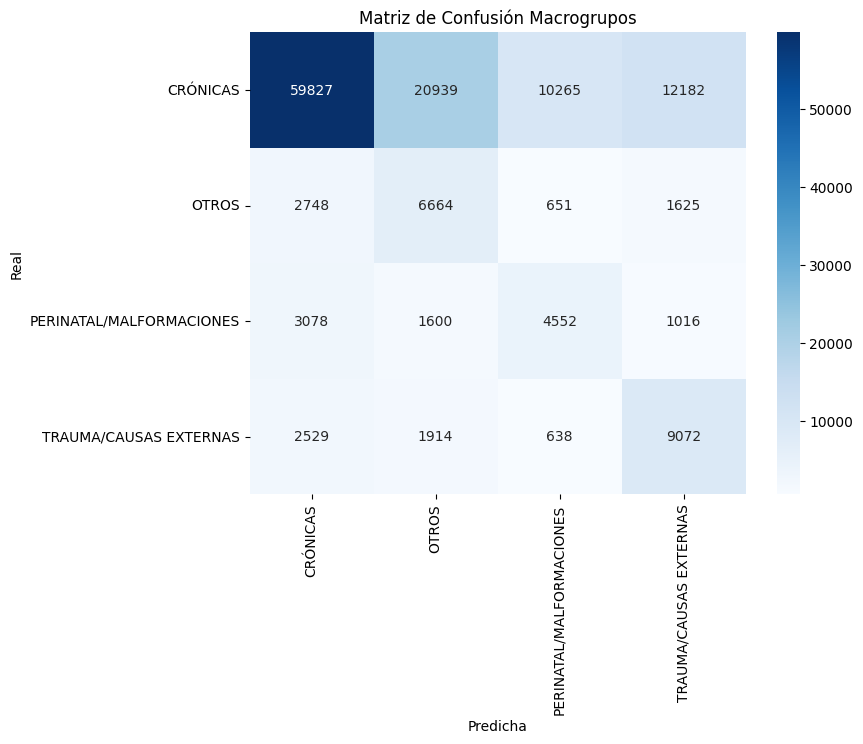

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

labels = ["CRÓNICAS", "OTROS", "PERINATAL/MALFORMACIONES", "TRAUMA/CAUSAS EXTERNAS"]
cm = confusion_matrix(y_test['macrogrupo'], y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicha')
plt.ylabel('Real')
plt.title('Matriz de Confusión Macrogrupos')
plt.show()


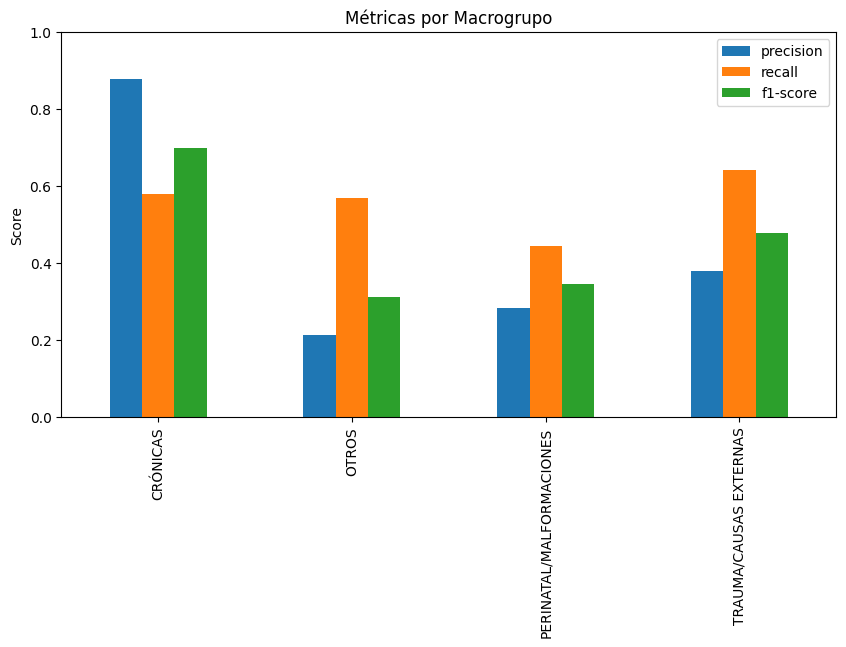

In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_test['macrogrupo'], y_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
df_metrics = pd.DataFrame(report).T.loc[labels, metrics]

df_metrics.plot(kind='bar', figsize=(10,5))
plt.title('Métricas por Macrogrupo')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()


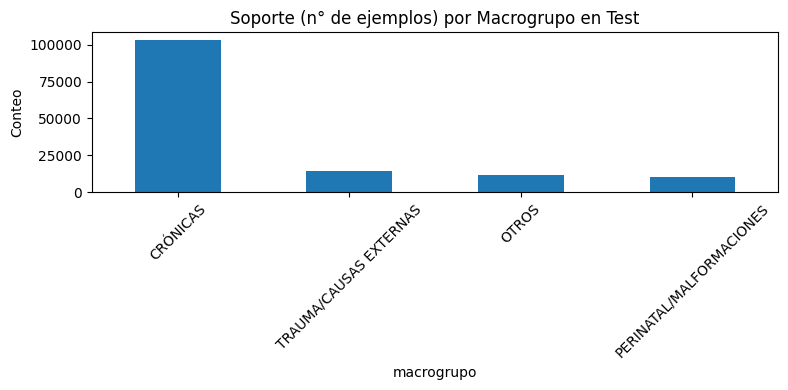

In [26]:
plt.figure(figsize=(8,4))
y_test['macrogrupo'].value_counts().plot(kind='bar')
plt.title('Soporte (n° de ejemplos) por Macrogrupo en Test')
plt.ylabel('Conteo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test['macrogrupo'], y_pred, labels=macrogrupos)
cm_df = pd.DataFrame(cm, index=macrogrupos, columns=macrogrupos)
# Quita la diagonal principal
off_diag = cm_df.copy()
np.fill_diagonal(off_diag.values, 0)
top_confusions = off_diag.stack().sort_values(ascending=False).head(10)

print("Top 10 confusiones fuera de la diagonal:")
print(top_confusions)


Top 10 confusiones fuera de la diagonal:
CRÓNICAS                  OTROS                       20939
                          TRAUMA/CAUSAS EXTERNAS      12182
                          PERINATAL/MALFORMACIONES    10265
PERINATAL/MALFORMACIONES  CRÓNICAS                     3078
OTROS                     CRÓNICAS                     2748
TRAUMA/CAUSAS EXTERNAS    CRÓNICAS                     2529
                          OTROS                        1914
OTROS                     TRAUMA/CAUSAS EXTERNAS       1625
PERINATAL/MALFORMACIONES  OTROS                        1600
                          TRAUMA/CAUSAS EXTERNAS       1016
dtype: int64


## KNN

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

RND = 123
N_TUNING = 15000   # O menos si tu RAM es limitada
N_TRAIN = 150000   # O lo que soporte tu máquina

# Muestreo para tuning y entrenamiento
X_tune, _, y_tune, _ = train_test_split(
    X_balanced, y_balanced,
    train_size=N_TUNING,
    stratify=y_balanced,
    random_state=RND
)
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_balanced, y_balanced,
    train_size=N_TRAIN,
    stratify=y_balanced,
    random_state=RND + 1
)


In [23]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # 1=Manhattan, 2=Euclidiana
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

gs = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=  10.1s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   8.5s
[CV] END ................n_neighbors=3, p=1, weights=uniform; total time=   8.4s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   8.2s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   8.1s
[CV] END ...............n_neighbors=3, p=1, weights=distance; total time=   8.1s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.8s
[CV] END ................n_neighbors=3, p=2, weights=uniform; total time=   0.8s
[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.5s
[CV] END ...............n_neighbors=3, p=2, weights=distance; total time=   0.5s
[CV] END ...............n_neighbors=3, p=2, weig

In [24]:
knn_final = KNeighborsClassifier(
    **gs.best_params_,
    n_jobs=-1
)
knn_final.fit(X_train_sub, y_train_sub)


KNeighborsClassifier(n_jobs=-1, n_neighbors=11, p=1, weights='distance')

In [26]:
# --- Paso 1: Alinea y rellena columnas faltantes en X_test ---
missing_in_test = X_train_sub.columns.difference(X_test.columns)
for col in missing_in_test:
    X_test[col] = 0  # Rellena con ceros (OHE)

# Ahora asegúrate de que el orden sea idéntico
X_test_aligned = X_test[X_train_sub.columns]

# --- Paso 2: Verifica ---
assert list(X_test_aligned.columns) == list(X_train_sub.columns), "Las columnas no están alineadas"

# --- Paso 3: Predicción ---
y_pred = knn_final.predict(X_test_aligned)


from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

clases_en_test = sorted(y_test.unique())
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test, y_pred))
print("Classification report (solo clases presentes en test):\n",
      classification_report(y_test, y_pred, labels=clases_en_test))
print("Confusion matrix (solo clases presentes en test):\n",
      confusion_matrix(y_test, y_pred, labels=clases_en_test))


C:\Users\rodri\AppData\Local\Temp\ipykernel_24596\4220169314.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0  # Rellena con ceros (OHE)
C:\Users\rodri\AppData\Local\Temp\ipykernel_24596\4220169314.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[col] = 0  # Rellena con ceros (OHE)
C:\Users\rodri\AppData\Local\Temp\ipykernel_24596\4220169314.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Test accuracy: 0.2516459850271767
Cohen's kappa: 0.003604724535638315
Classification report (solo clases presentes en test):
                           precision    recall  f1-score   support

                CRÓNICAS       0.75      0.29      0.42     72249
                   OTROS       0.10      0.21      0.14      8182
PERINATAL/MALFORMACIONES       0.17      0.18      0.18      7172
  TRAUMA/CAUSAS EXTERNAS       0.03      0.04      0.03      9907

               micro avg       0.37      0.25      0.30     97510
               macro avg       0.26      0.18      0.19     97510
            weighted avg       0.58      0.25      0.34     97510

Confusion matrix (solo clases presentes en test):
 [[21156 11392  5808 11893]
 [ 3309  1691    99   675]
 [ 2437   785  1292   623]
 [ 1432  2239   251   399]]


## RNA

In [39]:
import numpy as np
import pandas as pd

def ensure_numeric_no_na(X, cols=None, fill_value=0, verbose=True):
    if cols is None:
        cols = X.columns
    X = X.copy()
    for col in cols:
        X[col] = pd.to_numeric(X[col], errors='coerce')
        n_na = X[col].isnull().sum()
        n_inf = np.isinf(X[col]).sum()
        if verbose and (n_na > 0 or n_inf > 0):
            print(f"Col {col}: {n_na} NA, {n_inf} Inf, rellenando con {fill_value}")
        X[col] = X[col].fillna(fill_value)
        X[col] = X[col].replace([np.inf, -np.inf], fill_value)
    # Filtra columnas que no quedaron como numéricas
    X = X.select_dtypes(include=[np.number])
    return X.astype(np.float32)





In [36]:
# --------------- CARGA Y MUESTREO ---------------
from sklearn.model_selection import train_test_split

RND = 123
N_TUNING = 10000
N_TRAIN = 100000

# Asume que tienes X_balanced, y_balanced ya cargados correctamente.
# Muestreo para tuning
X_tune, _, y_tune, _ = train_test_split(
    X_balanced, y_balanced,
    train_size=N_TUNING,
    stratify=y_balanced,
    random_state=RND
)

# Muestreo para entrenamiento final
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_balanced, y_balanced,
    train_size=N_TRAIN,
    stratify=y_balanced,
    random_state=RND + 1
)

# --------------- PREPROCESAMIENTO DE COLUMNAS ---------------
# Asegura que el conjunto de columnas es el mismo
common_cols = X_train_sub.columns.intersection(X_test.columns)

# Preprocesa tuning, train y test con mismas columnas
X_tune_clean        = ensure_numeric_no_na(X_tune[common_cols])
X_train_sub_clean   = ensure_numeric_no_na(X_train_sub[common_cols])
X_test_clean        = ensure_numeric_no_na(X_test[common_cols])

print("¿NAs en tuning?:", X_tune_clean.isnull().sum().sum())
print("¿Inf en tuning?:", np.isinf(X_tune_clean.values).sum())
print("Shape final X_tune:", X_tune_clean.shape)
print("¿Shape test?:", X_test_clean.shape)

¿NAs en tuning?: 0
¿Inf en tuning?: 0
Shape final X_tune: (10000, 256)
¿Shape test?: (97510, 256)


In [38]:
print(X_tune_clean.info())
print("¿Todas son float?", all(X_tune_clean.dtypes == np.float32))
print("¿Hay columnas tipo objeto?", X_tune_clean.dtypes[X_tune_clean.dtypes == "object"])
print("¿Shape y valores únicos en y?", X_tune_clean.shape, np.unique(y_tune, return_counts=True))


<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 282275 to 657731
Columns: 256 entries, Añoreg to icd_group_SÍNTOMAS, SIGNOS Y RESULTADOS ANORMALES DE PRUEBAS COMPLEMENTARIAS, NO CLASIFICADOS BAJO OTRO CONCEPTO
dtypes: float32(256)
memory usage: 9.8 MB
None
¿Todas son float? True
¿Hay columnas tipo objeto? Series([], dtype: object)
¿Shape y valores únicos en y? (10000, 256) (array(['CRÓNICAS', 'INFECCIOSAS', 'OTROS', 'PERINATAL/MALFORMACIONES',
       'SÍNTOMAS/SIGNOS', 'TRAUMA/CAUSAS EXTERNAS'], dtype=object), array([1818, 1636, 1637, 1636, 1637, 1636]))


In [40]:
print("¿Target tiene NAs?", y_tune.isnull().sum())
print("¿Clases target?", np.unique(y_tune, return_counts=True))


¿Target tiene NAs? 0
¿Clases target? (array(['CRÓNICAS', 'INFECCIOSAS', 'OTROS', 'PERINATAL/MALFORMACIONES',
       'SÍNTOMAS/SIGNOS', 'TRAUMA/CAUSAS EXTERNAS'], dtype=object), array([1818, 1636, 1637, 1636, 1637, 1636]))


In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [100],
}

cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RND)

mlp = MLPClassifier(
    random_state=RND,
    # Quita early_stopping por ahora
    # early_stopping=True,
    n_iter_no_change=5,
    verbose=True
)

gs = GridSearchCV(
    mlp,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2,
    error_score='raise'  # así ves errores explícitos
)

try:
    gs.fit(X_tune_clean, y_tune)
    print("Mejores hiperparámetros:", gs.best_params_)
except Exception as e:
    print("ERROR GRIDSEARCH:", type(e), e)
    import traceback
    traceback.print_exc()


Fitting 2 folds for each of 24 candidates, totalling 48 fits
Iteration 1, loss = 1.56466818
Iteration 2, loss = 1.12212884
Iteration 3, loss = 0.79532737
Iteration 4, loss = 0.54146087
Iteration 5, loss = 0.38312992
Iteration 6, loss = 0.29526803
Iteration 7, loss = 0.24914810
Iteration 8, loss = 0.22191522
Iteration 9, loss = 0.20376448
Iteration 10, loss = 0.19245817
Iteration 11, loss = 0.18354297
Iteration 12, loss = 0.17731081
Iteration 13, loss = 0.17235510
Iteration 14, loss = 0.17000647
Iteration 15, loss = 0.16579758
Iteration 16, loss = 0.16349201
Iteration 17, loss = 0.16034162
Iteration 18, loss = 0.15885983
Iteration 19, loss = 0.15566520
Iteration 20, loss = 0.15338941
Iteration 21, loss = 0.15060470
Iteration 22, loss = 0.14931139
Iteration 23, loss = 0.14730284
Iteration 24, loss = 0.14588673
Iteration 25, loss = 0.14491475
Iteration 26, loss = 0.14226751
Iteration 27, loss = 0.14075257
Iteration 28, loss = 0.13741723
Iteration 29, loss = 0.13666376
Iteration 30, loss =

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
mlp_final = MLPClassifier(
    **gs.best_params_,
    random_state=RND,
    # early_stopping=True,   # <---- QUITA early_stopping aquí
    n_iter_no_change=10,
    verbose=True
)
mlp_final.fit(X_train_sub_clean, y_train_sub)


Iteration 1, loss = 0.57107663
Iteration 2, loss = 0.18430178
Iteration 3, loss = 0.17121702
Iteration 4, loss = 0.16510889
Iteration 5, loss = 0.16012046
Iteration 6, loss = 0.15640634
Iteration 7, loss = 0.15343742
Iteration 8, loss = 0.15094441
Iteration 9, loss = 0.14877909
Iteration 10, loss = 0.14708363
Iteration 11, loss = 0.14534521
Iteration 12, loss = 0.14365287
Iteration 13, loss = 0.14230362
Iteration 14, loss = 0.14161421
Iteration 15, loss = 0.13958237
Iteration 16, loss = 0.13873301
Iteration 17, loss = 0.13750656
Iteration 18, loss = 0.13681866
Iteration 19, loss = 0.13555530
Iteration 20, loss = 0.13457525
Iteration 21, loss = 0.13399428
Iteration 22, loss = 0.13307711
Iteration 23, loss = 0.13220879
Iteration 24, loss = 0.13172963
Iteration 25, loss = 0.13070223
Iteration 26, loss = 0.13008177
Iteration 27, loss = 0.12919125
Iteration 28, loss = 0.12887442
Iteration 29, loss = 0.12811397
Iteration 30, loss = 0.12746103
Iteration 31, loss = 0.12704982
Iteration 32, los

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, hidden_layer_sizes=(50,), max_iter=100,
              random_state=123, verbose=True)

In [45]:
y_pred = mlp_final.predict(X_test_clean)

from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test accuracy: 0.4736744949235976
Cohen's kappa: 0.007105748022062652


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Classification report:
                           precision    recall  f1-score   support

                CRÓNICAS       0.74      0.59      0.66     72249
             INFECCIOSAS       0.00      0.00      0.00         0
                   OTROS       0.08      0.08      0.08      8182
PERINATAL/MALFORMACIONES       0.10      0.27      0.15      7172
         SÍNTOMAS/SIGNOS       0.00      0.00      0.00         0
  TRAUMA/CAUSAS EXTERNAS       0.07      0.07      0.07      9907

                accuracy                           0.47     97510
               macro avg       0.17      0.17      0.16     97510
            weighted avg       0.57      0.47      0.51     97510

Confusion matrix:
 [[42901  1425  5529 13587  1005  7802]
 [    0     0     0     0     0     0]
 [ 5131    82   653  1576   109   631]
 [ 2901   178  1465  1910    78   640]
 [    0     0     0     0     0     0]
 [ 6821   211   492  1284   375   724]]


In [ ]:
y_pred = lr_final.predict(X_test_aligned)

# 3. Evaluación
print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test, y_pred))
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test accuracy: 0.1383037637165419
Cohen's kappa: 0.0012125510260448946


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

Classification report:
                           precision    recall  f1-score   support

                CRÓNICAS       0.76      0.10      0.18     72249
             INFECCIOSAS       0.00      0.00      0.00         0
                   OTROS       0.09      0.59      0.16      8182
PERINATAL/MALFORMACIONES       0.16      0.11      0.13      7172
         SÍNTOMAS/SIGNOS       0.00      0.00      0.00         0
  TRAUMA/CAUSAS EXTERNAS       0.04      0.05      0.04      9907

                accuracy                           0.14     97510
               macro avg       0.18      0.14      0.08     97510
            weighted avg       0.59      0.14      0.16     97510

Confusion matrix:
 [[ 7405  6501 39548  3734  4423 10638]
 [    0     0     0     0     0     0]
 [ 1370   626  4826    12   590   758]
 [  452   956  3882   762   310   810]
 [    0     0     0     0     0     0]
 [  512   419  5781   163  2539   493]]


## Nivel 2

In [37]:
import pandas as pd
import re
from pathlib import Path

train_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")
y_train = pd.read_csv(train_dir / "y_train.csv")

# Determina el nombre de la columna
codigo_col = None
for c in ['target', 'Caudef']:
    if c in y_train.columns:
        codigo_col = c
        break
if not codigo_col:
    raise Exception("No se encontró columna de códigos CIE-10 en y_train.")

# Visualiza ejemplos problemáticos
ejemplos_x = y_train[y_train[codigo_col].str.startswith("X", na=False)][codigo_col].unique()
print("Ejemplos de códigos que empiezan con X:", ejemplos_x[:20])

# Método A: Filtra códigos de suicidio/autolesión permitiendo 3 o 4 dígitos y sufijos
def es_suicidio_autolesion(cod):
    cod = str(cod)
    # Normaliza ceros a la izquierda (ej. X060)
    m = re.match(r"^X0?([6-8][0-9])", cod)
    if m:
        n = int(m.group(1))
        return 60 <= n <= 84
    # Alternativamente, busca exactamente los patrones X60...X84
    m2 = re.match(r"^X([6-8][0-9])", cod)
    if m2:
        n2 = int(m2.group(1))
        return 60 <= n2 <= 84
    # Si el código es tipo X649, toma solo los primeros tres caracteres (X64)
    m3 = re.match(r"^(X[6-8][0-9])", cod)
    if m3:
        n3 = int(m3.group(0)[1:])
        return 60 <= n3 <= 84
    return False

# Prueba en todo el dataset
suicidio_mask = y_train[codigo_col].apply(es_suicidio_autolesion)
suicidio_codigos = y_train.loc[suicidio_mask, codigo_col].unique()
print(f"Total de códigos de suicidio/autolesión (X60-X84): {suicidio_mask.sum()}")
print("Ejemplos de códigos identificados:", list(suicidio_codigos))

# EXTRA: Busca X60-X84 en los primeros 3-4 caracteres y muestra todos los distintos formatos
for extra in range(600, 850):
    prefijo = f"X{extra}"
    matches = y_train[y_train[codigo_col].str.startswith(prefijo, na=False)][codigo_col].unique()
    if len(matches) > 0:
        print(f"Prefijo {prefijo} - Encontrados: {matches}")

# Si hay ceros, sufijos, etc., ajusta la regex de arriba.

# También puedes usar un filtrado simple:
suicidio_codigos_all = y_train[
    y_train[codigo_col].str.slice(0, 3).isin([f"X{n}" for n in range(60, 85)])
][codigo_col].unique()
print("Con filtrado por los 3 primeros caracteres:", suicidio_codigos_all)


Ejemplos de códigos que empiezan con X: ['X599' 'X689' 'X959' 'X950' 'X994' 'X709' 'X958' 'X999' 'X499' 'X954'
 'X489' 'X990' 'X099' 'X339' 'X590' 'X459' 'X919' 'X209' 'X953' 'X952']
Total de códigos de suicidio/autolesión (X60-X84): 4343
Ejemplos de códigos identificados: ['X689', 'X709', 'X699', 'X700', 'X749', 'X682', 'X680', 'X744', 'X708', 'X649', 'X690', 'X784', 'X745', 'X849', 'X704', 'X789', 'X669', 'X609', 'X702', 'X748', 'X692', 'X769', 'X719', 'X840', 'X701', 'X650', 'X740', 'X844', 'X839', 'X718', 'X694', 'X688', 'X695', 'X639', 'X706', 'X847', 'X707', 'X640', 'X848', 'X705', 'X684', 'X685', 'X659', 'X642', 'X679', 'X780', 'X809', 'X742', 'X747', 'X842', 'X619', 'X714', 'X698', 'X648', 'X644', 'X746', 'X741', 'X629', 'X610']
Prefijo X609 - Encontrados: ['X609']
Prefijo X610 - Encontrados: ['X610']
Prefijo X619 - Encontrados: ['X619']
Prefijo X629 - Encontrados: ['X629']
Prefijo X639 - Encontrados: ['X639']
Prefijo X640 - Encontrados: ['X640']
Prefijo X642 - Encontrados: ['X

In [56]:
import pandas as pd
import re
from pathlib import Path
from sklearn.utils import resample, shuffle

train_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")
y_train_raw = pd.read_csv(train_dir / "y_train.csv")
X_train_raw = pd.read_csv(train_dir / "X_train.csv")  # asegúrate que ambos estén alineados

# Paso 1: Determina nombre de columna
codigo_col = 'target' if 'target' in y_train_raw.columns else 'Caudef'

# Paso 2: Mapea macrogrupo SOLO para identificar trauma
def cie10_to_macrogrupo(code):
    code = str(code)
    if code >= "A00" and code <= "B99":
        return "INFECCIOSAS"
    elif code >= "C00" and code <= "N99":
        return "CRÓNICAS"
    elif code >= "O00" and code <= "Q99":
        return "PERINATAL/MALFORMACIONES"
    elif code >= "R00" and code <= "R99":
        return "SÍNTOMAS/SIGNOS"
    elif code >= "S00" and code <= "Y99":
        return "TRAUMA/CAUSAS EXTERNAS"
    else:
        return "OTROS"

y_train_raw['macrogrupo'] = y_train_raw[codigo_col].apply(cie10_to_macrogrupo)

# Paso 3: Filtra solo trauma, index alineado
mask_trauma = (y_train_raw['macrogrupo'] == "TRAUMA/CAUSAS EXTERNAS")
X_trauma = X_train_raw.loc[mask_trauma, :].reset_index(drop=True)
y_trauma = y_train_raw.loc[mask_trauma, :].reset_index(drop=True)

# Paso 4: Subclasifica trauma
def map_causa_trauma(cod):
    cod = str(cod)
    # Extrae solo los primeros tres dígitos y el prefijo
    if re.match(r"^X([6-8][0-9])", cod):
        n = int(cod[1:3])
        if 60 <= n <= 84:
            return "Suicidio/Autolesiones"
    if re.match(r"^X(8[5-9]|9[0-9])", cod) or re.match(r"^Y0[0-9]", cod):
        return "Homicidio/Agresión"
    if cod.startswith('V'):
        return "Accidente de Transporte"
    if cod.startswith('W') or re.match(r"^X([0-5][0-9])", cod) or re.match(r"^Y([1-9][0-9])", cod):
        return "Otros Accidentes"
    return "Otros"

y_trauma['causa_trauma'] = y_trauma[codigo_col].apply(map_causa_trauma)

# Paso 5: Imprime y revisa distribución
print("Distribución trauma (antes de balancear):")
print(y_trauma['causa_trauma'].value_counts(normalize=True).round(3))
print(y_trauma['causa_trauma'].value_counts())

# Si quieres, haz balanceo aquí con resample, como antes (¡ya no pierdes suicidio!)

# Paso 6: Guarda resultados
X_trauma.to_csv(train_dir / "X_train_trauma.csv", index=False)
y_trauma.to_csv(train_dir / "y_train_trauma.csv", index=False)


Distribución trauma (antes de balancear):
causa_trauma
Otros Accidentes           0.444
Homicidio/Agresión         0.282
Otros                      0.147
Accidente de Transporte    0.089
Suicidio/Autolesiones      0.037
Name: proportion, dtype: float64
causa_trauma
Otros Accidentes           51926
Homicidio/Agresión         32933
Otros                      17209
Accidente de Transporte    10427
Suicidio/Autolesiones       4343
Name: count, dtype: int64


In [42]:
import pandas as pd
from sklearn.utils import resample, shuffle
from pathlib import Path

# Paths
train_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")
X_trauma = pd.read_csv(train_dir / "X_train_trauma.csv")
y_trauma = pd.read_csv(train_dir / "y_train_trauma.csv")

# Parámetros: decide el tamaño objetivo de cada clase
# Elige el tamaño de la clase minoritaria MÁS GRANDE (no la más pequeña absoluta)
clase_counts = y_trauma['causa_trauma'].value_counts()
n_target = clase_counts.max()  # o usa min() para un set muy balanceado y pequeño

print("Conteo original:")
print(clase_counts)

# Balanceo
X_bal, y_bal = [], []

for clase, n_clase in clase_counts.items():
    mask = (y_trauma['causa_trauma'] == clase)
    X_c = X_trauma.loc[mask]
    y_c = y_trauma.loc[mask]
    
    if n_clase < n_target:
        # Oversample con reemplazo
        X_c_res, y_c_res = resample(
            X_c, y_c,
            replace=True,
            n_samples=n_target,
            random_state=123
        )
    elif n_clase > n_target:
        # Undersample sin reemplazo
        X_c_res, y_c_res = resample(
            X_c, y_c,
            replace=False,
            n_samples=n_target,
            random_state=123
        )
    else:
        X_c_res, y_c_res = X_c, y_c
    X_bal.append(X_c_res)
    y_bal.append(y_c_res)

X_trauma_bal = pd.concat(X_bal, ignore_index=True)
y_trauma_bal = pd.concat(y_bal, ignore_index=True)

# Mezcla filas para evitar orden por clase
X_trauma_bal, y_trauma_bal = shuffle(X_trauma_bal, y_trauma_bal, random_state=123)

print("\nDistribución balanceada:")
print(y_trauma_bal['causa_trauma'].value_counts(normalize=True).round(3))
print(y_trauma_bal['causa_trauma'].value_counts())

# Guarda
X_trauma_bal.to_csv(train_dir / "X_train_trauma_balanced.csv", index=False)
y_trauma_bal.to_csv(train_dir / "y_train_trauma_balanced.csv", index=False)


Conteo original:
causa_trauma
Otros Accidentes           51926
Homicidio/Agresión         32933
Otros                      17209
Accidente de Transporte    10427
Suicidio/Autolesiones       4343
Name: count, dtype: int64

Distribución balanceada:
causa_trauma
Otros                      0.2
Otros Accidentes           0.2
Suicidio/Autolesiones      0.2
Accidente de Transporte    0.2
Homicidio/Agresión         0.2
Name: proportion, dtype: float64
causa_trauma
Otros                      51926
Otros Accidentes           51926
Suicidio/Autolesiones      51926
Accidente de Transporte    51926
Homicidio/Agresión         51926
Name: count, dtype: int64


In [57]:
import pandas as pd
import re
from pathlib import Path

test_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\test")

# Carga los archivos originales de test
y_test_raw = pd.read_csv(test_dir / "y_test.csv")
X_test_raw = pd.read_csv(test_dir / "X_test.csv")  # Deben estar alineados

# Determina el nombre de la columna de código
codigo_col = 'target' if 'target' in y_test_raw.columns else 'Caudef'

# Macrogrupo solo para identificar trauma
def cie10_to_macrogrupo(code):
    code = str(code)
    if code >= "A00" and code <= "B99":
        return "INFECCIOSAS"
    elif code >= "C00" and code <= "N99":
        return "CRÓNICAS"
    elif code >= "O00" and code <= "Q99":
        return "PERINATAL/MALFORMACIONES"
    elif code >= "R00" and code <= "R99":
        return "SÍNTOMAS/SIGNOS"
    elif code >= "S00" and code <= "Y99":
        return "TRAUMA/CAUSAS EXTERNAS"
    else:
        return "OTROS"

y_test_raw['macrogrupo'] = y_test_raw[codigo_col].apply(cie10_to_macrogrupo)

# Filtra trauma con índices alineados
mask_trauma = (y_test_raw['macrogrupo'] == "TRAUMA/CAUSAS EXTERNAS")
X_test_trauma = X_test_raw.loc[mask_trauma, :].reset_index(drop=True)
y_test_trauma = y_test_raw.loc[mask_trauma, :].reset_index(drop=True)

# Subclasifica trauma igual que en train
def map_causa_trauma(cod):
    cod = str(cod)
    # Suicidio/autolesiones X60-X84 (tres primeros caracteres)
    if re.match(r"^X([6-8][0-9])", cod):
        n = int(cod[1:3])
        if 60 <= n <= 84:
            return "Suicidio/Autolesiones"
    if re.match(r"^X(8[5-9]|9[0-9])", cod) or re.match(r"^Y0[0-9]", cod):
        return "Homicidio/Agresión"
    if cod.startswith('V'):
        return "Accidente de Transporte"
    if cod.startswith('W') or re.match(r"^X([0-5][0-9])", cod) or re.match(r"^Y([1-9][0-9])", cod):
        return "Otros Accidentes"
    return "Otros"

y_test_trauma['causa_trauma'] = y_test_trauma[codigo_col].apply(map_causa_trauma)

# Imprime para verificar
print("Distribución trauma TEST (antes de balancear):")
print(y_test_trauma['causa_trauma'].value_counts(normalize=True).round(3))
print(y_test_trauma['causa_trauma'].value_counts())

# Guarda para modelado de nivel 2
X_test_trauma.to_csv(test_dir / "X_test_trauma.csv", index=False)
y_test_trauma.to_csv(test_dir / "y_test_trauma.csv", index=False)


Distribución trauma TEST (antes de balancear):
causa_trauma
Otros Accidentes           0.445
Homicidio/Agresión         0.282
Otros                      0.147
Accidente de Transporte    0.089
Suicidio/Autolesiones      0.037
Name: proportion, dtype: float64
causa_trauma
Otros Accidentes           22263
Homicidio/Agresión         14108
Otros                       7374
Accidente de Transporte     4468
Suicidio/Autolesiones       1862
Name: count, dtype: int64


In [52]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

RND = 123
train_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")

# Carga sets balanceados (de trauma, nivel 2)
X = pd.read_csv(train_dir / "X_train_trauma_balanced.csv")
y = pd.read_csv(train_dir / "y_train_trauma_balanced.csv")['causa_trauma']

# 1. Submuestreo para tuning de hiperparámetros (más chico)
N_TUNE = 20000
X_tune, _, y_tune, _ = train_test_split(
    X, y, 
    train_size=N_TUNE, 
    stratify=y, 
    random_state=RND
)

# 2. Submuestreo para entrenamiento final (puede ser todo, o más grande)
N_TRAIN = 100000
X_train, _, y_train, _ = train_test_split(
    X, y, 
    train_size=N_TRAIN, 
    stratify=y, 
    random_state=RND + 1
)

In [49]:
# 3. Grid de hiperparámetros (ajusta según el modelo)
param_grid = {
    'max_depth': [10, 20, None],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [100, 200]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

gs = GridSearchCV(
    RandomForestClassifier(
        max_features='sqrt',
        class_weight='balanced_subsample',
        random_state=RND,
        n_jobs=-1
    ),
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.2s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.1s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=100; total time=   1.1s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   2.2s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   2.1s
[CV] END .max_depth=10, min_samples_leaf=1, n_estimators=200; total time=   2.1s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   1.1s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=100; total time=   1.0s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=   2.0s
[CV] END .max_depth=10, min_samples_leaf=5, n_estimators=200; total time=   2.0s
[CV] END .max_depth=10, min_samples_leaf=5, n_es

In [53]:
rf_final2 = RandomForestClassifier(
    **gs.best_params_,
    max_features='sqrt',
    class_weight='balanced_subsample',
    random_state=RND,
    n_jobs=-1
)
rf_final2.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced_subsample', n_estimators=200,
                       n_jobs=-1, random_state=123)

In [60]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Asegura que solo usas la columna correcta:
y_true = y_test_trauma['causa_trauma'] if isinstance(y_test_trauma, pd.DataFrame) else y_test_trauma

print("Test accuracy:", accuracy_score(y_true, y_pred_test))
print("Classification report:\n", classification_report(y_true, y_pred_test))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_test))


Test accuracy: 0.666480279580629
Classification report:
                          precision    recall  f1-score   support

Accidente de Transporte       0.39      0.57      0.46      4468
     Homicidio/Agresión       0.59      0.61      0.60     14108
                  Otros       1.00      1.00      1.00      7374
       Otros Accidentes       0.74      0.64      0.69     22263
  Suicidio/Autolesiones       0.25      0.33      0.28      1862

               accuracy                           0.67     50075
              macro avg       0.59      0.63      0.61     50075
           weighted avg       0.69      0.67      0.67     50075

Confusion matrix:
 [[ 2527   745     0  1001   195]
 [ 1615  8561     0  3452   480]
 [    0     0  7374     0     0]
 [ 2148  4689     0 14306  1120]
 [  256   394     0   606   606]]


## Regresión Logística

In [51]:
import pandas as pd
import re
from pathlib import Path

test_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\test")

# Carga los archivos originales de test
y_test_raw = pd.read_csv(test_dir / "y_test.csv")
X_test_raw = pd.read_csv(test_dir / "X_test.csv")  # Deben estar alineados

# Determina el nombre de la columna de código
codigo_col = 'target' if 'target' in y_test_raw.columns else 'Caudef'

# Macrogrupo solo para identificar trauma
def cie10_to_macrogrupo(code):
    code = str(code)
    if code >= "A00" and code <= "B99":
        return "INFECCIOSAS"
    elif code >= "C00" and code <= "N99":
        return "CRÓNICAS"
    elif code >= "O00" and code <= "Q99":
        return "PERINATAL/MALFORMACIONES"
    elif code >= "R00" and code <= "R99":
        return "SÍNTOMAS/SIGNOS"
    elif code >= "S00" and code <= "Y99":
        return "TRAUMA/CAUSAS EXTERNAS"
    else:
        return "OTROS"

y_test_raw['macrogrupo'] = y_test_raw[codigo_col].apply(cie10_to_macrogrupo)

# Filtra trauma con índices alineados
mask_trauma = (y_test_raw['macrogrupo'] == "TRAUMA/CAUSAS EXTERNAS")
X_test_trauma = X_test_raw.loc[mask_trauma, :].reset_index(drop=True)
y_test_trauma = y_test_raw.loc[mask_trauma, :].reset_index(drop=True)

# Subclasifica trauma igual que en train
def map_causa_trauma(cod):
    cod = str(cod)
    # Suicidio/autolesiones X60-X84 (tres primeros caracteres)
    if re.match(r"^X([6-8][0-9])", cod):
        n = int(cod[1:3])
        if 60 <= n <= 84:
            return "Suicidio/Autolesiones"
    if re.match(r"^X(8[5-9]|9[0-9])", cod) or re.match(r"^Y0[0-9]", cod):
        return "Homicidio/Agresión"
    if cod.startswith('V'):
        return "Accidente de Transporte"
    if cod.startswith('W') or re.match(r"^X([0-5][0-9])", cod) or re.match(r"^Y([1-9][0-9])", cod):
        return "Otros Accidentes"
    return "Otros"

y_test_trauma['causa_trauma'] = y_test_trauma[codigo_col].apply(map_causa_trauma)

# Imprime para verificar
print("Distribución trauma TEST (antes de balancear):")
print(y_test_trauma['causa_trauma'].value_counts(normalize=True).round(3))
print(y_test_trauma['causa_trauma'].value_counts())

# Guarda para modelado de nivel 2
X_test_trauma.to_csv(test_dir / "X_test_trauma.csv", index=False)
y_test_trauma.to_csv(test_dir / "y_test_trauma.csv", index=False)

Distribución trauma TEST (antes de balancear):
causa_trauma
Otros Accidentes           0.445
Homicidio/Agresión         0.282
Otros                      0.147
Accidente de Transporte    0.089
Suicidio/Autolesiones      0.037
Name: proportion, dtype: float64
causa_trauma
Otros Accidentes           22263
Homicidio/Agresión         14108
Otros                       7374
Accidente de Transporte     4468
Suicidio/Autolesiones       1862
Name: count, dtype: int64


In [54]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

RND = 123
train_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")

# Carga sets balanceados (de trauma, nivel 2)
X = pd.read_csv(train_dir / "X_train_trauma_balanced.csv")
y = pd.read_csv(train_dir / "y_train_trauma_balanced.csv")['causa_trauma']

# 1. Submuestreo para tuning de hiperparámetros (más chico)
N_TUNE = 20000
X_tune, _, y_tune, _ = train_test_split(
    X, y, 
    train_size=N_TUNE, 
    stratify=y, 
    random_state=RND
)

# 2. Submuestreo para entrenamiento final (puede ser todo, o más grande)
N_TRAIN = 100000
X_train, _, y_train, _ = train_test_split(
    X, y, 
    train_size=N_TRAIN, 
    stratify=y, 
    random_state=RND + 1
)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score

# --- Hiperparámetros y cross-validation ---
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [200],
    'multi_class': ['multinomial']
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

# --- GridSearch sobre tuning set ---
lr = LogisticRegression(class_weight='balanced', random_state=RND)
gs = GridSearchCV(
    lr, param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)



Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores hiperparámetros: {'C': 1, 'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs'}


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
# --- Entrenamiento final ---
lr_final = LogisticRegression(
    **gs.best_params_,
    class_weight='balanced',
    random_state=RND,
    n_jobs=-1
)
lr_final.fit(X_train, y_train)

# --- Asegura alineación de columnas en test ---
common_cols = X_train.columns.intersection(X_test_trauma.columns)
X_test_eval = X_test_trauma[common_cols].astype(float)  # fuerza numérico



c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [57]:

# --- Predicción y evaluación ---
y_true = y_test_trauma['causa_trauma'] if isinstance(y_test_trauma, pd.DataFrame) else y_test_trauma
y_pred_test = lr_final.predict(X_test_eval)

print("Test accuracy:", accuracy_score(y_true, y_pred_test))
print("Cohen's kappa:", cohen_kappa_score(y_true, y_pred_test))
print("Classification report:\n", classification_report(y_true, y_pred_test))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_test))

Test accuracy: 0.5575237144283575
Cohen's kappa: 0.4265480726362776
Classification report:
                          precision    recall  f1-score   support

Accidente de Transporte       0.29      0.54      0.38      4468
     Homicidio/Agresión       0.56      0.55      0.56     14108
                  Otros       1.00      1.00      1.00      7374
       Otros Accidentes       0.77      0.42      0.54     22263
  Suicidio/Autolesiones       0.12      0.54      0.20      1862

               accuracy                           0.56     50075
              macro avg       0.55      0.61      0.53     50075
           weighted avg       0.68      0.56      0.59     50075

Confusion matrix:
 [[2412  635    0  576  845]
 [2160 7773    0 2034 2141]
 [   0    0 7374    0    0]
 [3356 5106    0 9354 4447]
 [ 362  300    0  195 1005]]


## KNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# --- Definición de hiperparámetros y CV ---
param_grid = {
    'n_neighbors': [3, 5, 10, 20],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # Manhattan (1) y Euclídea (2)
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)

# --- Tuning de hiperparámetros (grid search) ---
knn = KNeighborsClassifier(n_jobs=-1)
gs_knn = GridSearchCV(
    knn,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs_knn.fit(X_tune, y_tune)
print("Mejores hiperparámetros (KNN):", gs_knn.best_params_)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores hiperparámetros (KNN): {'n_neighbors': 20, 'p': 1, 'weights': 'distance'}


In [59]:
# --- Entrenamiento final ---
knn_final = KNeighborsClassifier(
    **gs_knn.best_params_,
    n_jobs=-1
)
knn_final.fit(X_train, y_train)

# --- Alineación de columnas y tipo numérico ---
common_cols = X_train.columns.intersection(X_test_trauma.columns)
X_test_eval = X_test_trauma[common_cols].astype(float)  # Asegura tipo correcto



In [60]:
# --- Predicción y evaluación ---
y_true = y_test_trauma['causa_trauma'] if isinstance(y_test_trauma, pd.DataFrame) else y_test_trauma
y_pred_test = knn_final.predict(X_test_eval)

from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix

print("Test accuracy:", accuracy_score(y_true, y_pred_test))
print("Cohen's kappa:", cohen_kappa_score(y_true, y_pred_test))
print("Classification report:\n", classification_report(y_true, y_pred_test))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred_test))


Test accuracy: 0.5223364952571143
Cohen's kappa: 0.3858702208041024
Classification report:
                          precision    recall  f1-score   support

Accidente de Transporte       0.27      0.46      0.34      4468
     Homicidio/Agresión       0.54      0.54      0.54     14108
                  Otros       0.91      0.99      0.94      7374
       Otros Accidentes       0.74      0.37      0.49     22263
  Suicidio/Autolesiones       0.11      0.54      0.18      1862

               accuracy                           0.52     50075
              macro avg       0.51      0.58      0.50     50075
           weighted avg       0.64      0.52      0.55     50075

Confusion matrix:
 [[2070  760   81  582  975]
 [2113 7574   95 2032 2294]
 [  24   13 7285    5   47]
 [3183 5487  567 8224 4802]
 [ 270  320   19  250 1003]]


## RNA 

In [108]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
import numpy as np

# Codificar las etiquetas de clase
label_encoder = LabelEncoder()
y_tune_encoded = label_encoder.fit_transform(y_tune_clean)
y_train_encoded = label_encoder.transform(y_train_clean)
y_test_encoded = label_encoder.transform(y_test_clean)

# Asegurar que las características sean de tipo float
X_tune_clean = X_tune_clean.astype(np.float64)
X_train_clean = X_train_clean.astype(np.float64)
X_test_clean = X_test_clean.astype(np.float64)

In [109]:
# Definir el modelo y la búsqueda de hiperparámetros
mlp = MLPClassifier(random_state=123, max_iter=100, verbose=True)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
gs_mlp = GridSearchCV(
    mlp,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)

# Ajustar el modelo
gs_mlp.fit(X_tune_clean, y_tune_encoded)
print("Mejores hiperparámetros (MLP):", gs_mlp.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Iteration 1, loss = 1.13661505
Iteration 2, loss = 0.91525169
Iteration 3, loss = 0.87753848
Iteration 4, loss = 0.85466721
Iteration 5, loss = 0.83454579
Iteration 6, loss = 0.82111270
Iteration 7, loss = 0.80695703
Iteration 8, loss = 0.79144272
Iteration 9, loss = 0.77792528
Iteration 10, loss = 0.76696385
Iteration 11, loss = 0.75392211
Iteration 12, loss = 0.74053697
Iteration 13, loss = 0.72817129
Iteration 14, loss = 0.71935772
Iteration 15, loss = 0.70780987
Iteration 16, loss = 0.69767513
Iteration 17, loss = 0.68521095
Iteration 18, loss = 0.67197736
Iteration 19, loss = 0.66799123
Iteration 20, loss = 0.65181206
Iteration 21, loss = 0.64487439
Iteration 22, loss = 0.63560101
Iteration 23, loss = 0.62787003
Iteration 24, loss = 0.61476902
Iteration 25, loss = 0.60775375
Iteration 26, loss = 0.59954693
Iteration 27, loss = 0.58854519
Iteration 28, loss = 0.58329178
Iteration 29, loss = 0.57216844
Iteration 30, loss =

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [110]:
mlp_final = MLPClassifier(
    **gs_mlp.best_params_,
    random_state=123,
    max_iter=100,
    verbose=True
)
mlp_final.fit(X_train_clean, y_train_encoded)


Iteration 1, loss = 0.93853821
Iteration 2, loss = 0.83547928
Iteration 3, loss = 0.80496531
Iteration 4, loss = 0.78115520
Iteration 5, loss = 0.75976853
Iteration 6, loss = 0.74081367
Iteration 7, loss = 0.72216940
Iteration 8, loss = 0.70561025
Iteration 9, loss = 0.69048210
Iteration 10, loss = 0.67700952
Iteration 11, loss = 0.66370859
Iteration 12, loss = 0.65447986
Iteration 13, loss = 0.64391042
Iteration 14, loss = 0.63339346
Iteration 15, loss = 0.62410002
Iteration 16, loss = 0.61720699
Iteration 17, loss = 0.61105190
Iteration 18, loss = 0.60291452
Iteration 19, loss = 0.59479724
Iteration 20, loss = 0.59042620
Iteration 21, loss = 0.58473080
Iteration 22, loss = 0.58016622
Iteration 23, loss = 0.57189452
Iteration 24, loss = 0.56923723
Iteration 25, loss = 0.56476245
Iteration 26, loss = 0.55946053
Iteration 27, loss = 0.55594612
Iteration 28, loss = 0.55408577
Iteration 29, loss = 0.55055361
Iteration 30, loss = 0.54618732
Iteration 31, loss = 0.54213323
Iteration 32, los

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 50), max_iter=100,
              random_state=123, verbose=True)

In [111]:

# Realizar predicciones y evaluar el modelo
y_pred = mlp_final.predict(X_test_clean)
print("Precisión en el conjunto de prueba:", accuracy_score(y_test_encoded, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test_encoded, y_pred))
print("Informe de clasificación:\n", classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))
print("Matriz de confusión:\n", confusion_matrix(y_test_encoded, y_pred))

Precisión en el conjunto de prueba: 0.6109036445332002
Cohen's kappa: 0.46805368076083864
Informe de clasificación:
                          precision    recall  f1-score   support

Accidente de Transporte       0.32      0.50      0.39      4468
     Homicidio/Agresión       0.54      0.59      0.56     14108
                  Otros       1.00      1.00      1.00      7374
       Otros Accidentes       0.74      0.54      0.62     22263
  Suicidio/Autolesiones       0.16      0.34      0.22      1862

               accuracy                           0.61     50075
              macro avg       0.55      0.59      0.56     50075
           weighted avg       0.66      0.61      0.63     50075

Matriz de confusión:
 [[ 2240   962     0   877   389]
 [ 1902  8295     0  2899  1012]
 [    0     0  7371     0     3]
 [ 2674  5590     1 12056  1942]
 [  267   426     0   540   629]]


## Nivel 3

In [114]:
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Carga raw
train_dir = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\train")
test_dir  = Path(r"C:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\data\test")

raw_train = pd.read_csv(train_dir / "raw_train.csv")
raw_test  = pd.read_csv(test_dir  / "raw_test.csv")

# Filtro salud mental + ingeniería de variables cruzadas (idéntico para train/test)
def foco_salud_mental(code):
    import re
    code = str(code)
    if re.match(r'^X([6-8][0-9])', code):
        n = int(code[1:3])
        if 60 <= n <= 84:
            return "Suicidio/Autolesion"
    if re.match(r'^F\d{2}', code):
        return "OtroTrastornoMental"
    return None

def cruza_variables(df):
    edad_bins   = [0, 18, 40, 65, 120]
    edad_labels = ['joven','adulto','mayor','muy_mayor']
    df['edad_grupo']         = pd.cut(df['Edadif'], bins=edad_bins, labels=edad_labels)
    df['edad_sexo']          = df['edad_grupo'].astype(str) + "_" + df['Sexo'].astype(str)
    df['sexo_escolaridad']   = df['Sexo'].astype(str) + "_" + df['Escodif'].astype(str)
    df['depto_año']          = df['Depreg'].astype(str) + "_" + df['Añoreg'].astype(str)
    df['muni_año']           = df['Mupreg'].astype(str) + "_" + df['Añoreg'].astype(str)
    df['ecivil_edad']        = df['Ecidif'].astype(str) + "_" + df['edad_grupo'].astype(str)
    df['escolaridad_pueblo'] = df['Escodif'].astype(str) + "_" + df['Puedif'].astype(str)
    df['sitio_asistencia']   = df['Ocur'].astype(str) + "_" + df['Asist'].astype(str)
    return df

for df in [raw_train, raw_test]:
    df['salud_mental'] = df['Caudef'].apply(foco_salud_mental)
    cruza_variables(df)

# Filtra sólo salud mental/suicidio
train_mental = raw_train[raw_train['salud_mental'].notnull()].reset_index(drop=True)
test_mental  = raw_test [raw_test ['salud_mental'].notnull()].reset_index(drop=True)

X_train = train_mental.copy()
y_train = train_mental['salud_mental']
X_test  = test_mental.copy()
y_test  = test_mental['salud_mental']

# Reduce cardinalidad solo si hay problemas de RAM
for col in ['Depreg', 'Mupreg', 'depto_año', 'muni_año']:
    top = X_train[col].value_counts().nlargest(15).index  # top_n puede ser más grande
    X_train[col] = X_train[col].where(X_train[col].isin(top), other="Otros")
    X_test [col] = X_test [col].where(X_test [col].isin(top), other="Otros")

# Forzar categóricas a str, NAs a 'NA'
cat_feats = [
    'Depreg', 'Mupreg', 'Mesreg', 'Sexo', 'Perdif', 'Ecidif', 'Ocudif',
    'Dnadif', 'Mnadif', 'Nacdif', 'Dredif', 'Mredif',
    'Escodif', 'Puedif', 'Asist', 'Ocur', 'Cerdef',
    'edad_grupo', 'edad_sexo', 'sexo_escolaridad', 'depto_año', 'muni_año',
    'ecivil_edad', 'escolaridad_pueblo', 'sitio_asistencia'
]
cat_feats = list(set(cat_feats) & set(X_train.columns))  # solo si existen en tu df
for col in cat_feats:
    X_train[col] = X_train[col].astype(str).fillna('NA')
    X_test [col] = X_test [col].astype(str).fillna('NA')

# Variables numéricas
numeric_features = ['Edadif', 'Añoreg', 'Diaocu']
numeric_features = [c for c in numeric_features if c in X_train.columns]

# Preprocesamiento estándar (sin SMOTE ni balanceo)
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preproc = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, cat_feats)
])

# Fit-transform solo en train
X_train_proc = preproc.fit_transform(X_train)
X_test_proc  = preproc.transform(X_test)

# Puedes usar X_train_proc, X_test_proc para todos tus modelos (RF, LR, SVM, etc.)


In [115]:
# ------------------- Verificaciones e impresiones -------------------

print("="*40)
print("Tamaño raw original:")
print("Train:", raw_train.shape)
print("Test :", raw_test.shape)

print("\nTamaño tras filtro salud mental:")
print("Train:", train_mental.shape)
print("Test :", test_mental.shape)
print("-"*30)
print("Clases en y_train:")
print(y_train.value_counts(normalize=True).round(3))
print("-"*30)
print("Clases en y_test:")
print(y_test.value_counts(normalize=True).round(3))

print("\nVariables cruzadas (ejemplo primeros 3 columnas cruzadas, primeras 3 filas):")
print(X_train[['edad_sexo','sexo_escolaridad','depto_año']].head(3))

print("\nVariables categóricas finales usadas para OHE:")
print(cat_feats)
print(f"Total: {len(cat_feats)}")

print("\nVariables numéricas finales:")
print(numeric_features)
print(f"Total: {len(numeric_features)}")

print("="*40)
print("Forma final de X_train_proc:", X_train_proc.shape)
print("Forma final de X_test_proc :", X_test_proc.shape)

# Si quieres ver nombres de columnas codificadas (OHE) para debug:
cat_names = preproc.named_transformers_['cat']['onehot'].get_feature_names_out(cat_feats)
print("\nEjemplo de variables OHE generadas:")
print(cat_names[:10])

# Confirmar que no hay NAs en proc:
print("\n¿Hay NAs en X_train_proc?", pd.DataFrame(X_train_proc).isna().sum().sum())
print("¿Hay NAs en X_test_proc? ", pd.DataFrame(X_test_proc).isna().sum().sum())
print("="*40)

Tamaño raw original:
Train: (706112, 76)
Test : (302620, 76)

Tamaño tras filtro salud mental:
Train: (10406, 76)
Test : (4460, 76)
------------------------------
Clases en y_train:
salud_mental
OtroTrastornoMental    0.583
Suicidio/Autolesion    0.417
Name: proportion, dtype: float64
------------------------------
Clases en y_test:
salud_mental
OtroTrastornoMental    0.583
Suicidio/Autolesion    0.417
Name: proportion, dtype: float64

Variables cruzadas (ejemplo primeros 3 columnas cruzadas, primeras 3 filas):
          edad_sexo      sexo_escolaridad         depto_año
0  muy_mayor_Hombre       Hombre_Primaria             Otros
1      mayor_Hombre  Hombre_Diversificado  Guatemala_2015.0
2       mayor_Mujer   Mujer_Diversificado  Guatemala_2010.0

Variables categóricas finales usadas para OHE:
['ecivil_edad', 'muni_año', 'Puedif', 'Mredif', 'sexo_escolaridad', 'Asist', 'Ocudif', 'Mesreg', 'Sexo', 'Nacdif', 'edad_sexo', 'sitio_asistencia', 'Dredif', 'Mupreg', 'Perdif', 'edad_grupo', 'Dn

In [95]:
from sklearn.utils import resample

N_TUNING = 5000   # Usa un N que tu RAM tolere
N_TRAIN_FINAL = 8000  # Ejemplo, puedes ajustar

# --- Muestreo para tuning (sobre arrays ya codificados, NO dataframes originales) ---
X_tune, y_tune = resample(
    X_train_proc, y_train,
    n_samples=min(N_TUNING, len(X_train_proc)),
    replace=False,
    stratify=y_train,
    random_state=123
)

# --- Muestreo para entrenamiento final ---
X_train_sub, y_train_sub = resample(
    X_train_proc, y_train,
    n_samples=min(N_TRAIN_FINAL, len(X_train_proc)),
    replace=False,
    stratify=y_train,
    random_state=124
)


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_leaf': [1, 5, 10],
    'n_estimators': [50, 100]
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)

gs = GridSearchCV(
    RandomForestClassifier(random_state=123, n_jobs=-1),
    param_grid,
    cv=cv,
    scoring='f1_macro',
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=50; total time=   0.5s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=1, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=1, n_estimators=100; total time=   0.4s
[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=5, min_samples_leaf=5, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=5, min_samples_leaf=5, n_estimators=100; total time=   0.5s
[CV] END ..max_depth=5, min_samples_leaf=5, n_es

In [97]:
rf_final = RandomForestClassifier(
    **gs.best_params_,
    random_state=123,
    n_jobs=-1
)
rf_final.fit(X_train_sub, y_train_sub)


RandomForestClassifier(n_jobs=-1, random_state=123)

In [98]:
# Evaluación
y_pred = rf_final.predict(X_test_proc)
from sklearn.metrics import classification_report, confusion_matrix

print("Test accuracy:", (y_test == y_pred).mean())
print("Classification report:\n", classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Test accuracy: 0.8903587443946188
Classification report:
                      precision    recall  f1-score   support

OtroTrastornoMental       0.89      0.92      0.91      2598
Suicidio/Autolesion       0.89      0.85      0.87      1862

           accuracy                           0.89      4460
          macro avg       0.89      0.88      0.89      4460
       weighted avg       0.89      0.89      0.89      4460

Confusion matrix:
 [[2397  201]
 [ 288 1574]]


In [99]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Asume que ya tienes esto definido ---
# X_train_proc, X_test_proc: datos procesados con OHE
# y_train, y_test: "salud_mental" (Suicidio/Autolesion u OtroTrastornoMental)
# train_mental, test_mental: DataFrames originales filtrados a salud mental (para extraer Caudef original)
# (Si no los tienes, puedes crearlos igual que antes del preproceso)

# ---------- SUBGRUPO 1: SUICIDIO/AUTOLESION ----------
print("\n\n=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===")
mask_suicidio_train = y_train == "Suicidio/Autolesion"
mask_suicidio_test  = y_test  == "Suicidio/Autolesion"

X_suicidio_train = X_train_proc[mask_suicidio_train]
y_suicidio_train = train_mental.loc[mask_suicidio_train, 'Caudef']

X_suicidio_test  = X_test_proc[mask_suicidio_test]
y_suicidio_test  = test_mental.loc[mask_suicidio_test, 'Caudef']

# Top N subclases de suicidio/autolesión
top_x = y_suicidio_train.value_counts().nlargest(5).index
print("Top subclases X (train):", top_x.tolist())

mask_top_x_train = y_suicidio_train.isin(top_x)
mask_top_x_test  = y_suicidio_test.isin(top_x)

X_suicidio_train_top = X_suicidio_train[mask_top_x_train]
y_suicidio_train_top = y_suicidio_train[mask_top_x_train]
X_suicidio_test_top  = X_suicidio_test[mask_top_x_test]
y_suicidio_test_top  = y_suicidio_test[mask_top_x_test]

print("\nDistribución de clases en train (subgrupo X):")
print(y_suicidio_train_top.value_counts(normalize=True).round(3))

# Modelo RF subclases suicidio/autolesion
rf_suicidio = RandomForestClassifier(random_state=123)
rf_suicidio.fit(X_suicidio_train_top, y_suicidio_train_top)

y_pred_suicidio = rf_suicidio.predict(X_suicidio_test_top)
print("\nClassification report (subclases suicidio/autolesion):")
print(classification_report(y_suicidio_test_top, y_pred_suicidio))
print("Confusion matrix:")
print(confusion_matrix(y_suicidio_test_top, y_pred_suicidio))


# ---------- SUBGRUPO 2: OTRO TRASTORNO MENTAL ----------
print("\n\n=== SUBGRUPO 2: OTRO TRASTORNO MENTAL ===")
mask_otro_train = y_train == "OtroTrastornoMental"
mask_otro_test  = y_test  == "OtroTrastornoMental"

X_otro_train = X_train_proc[mask_otro_train]
y_otro_train = train_mental.loc[mask_otro_train, 'Caudef']

X_otro_test  = X_test_proc[mask_otro_test]
y_otro_test  = test_mental.loc[mask_otro_test, 'Caudef']

# Top N subclases F más comunes
top_f = y_otro_train.value_counts().nlargest(5).index
print("Top subclases F (train):", top_f.tolist())

mask_top_f_train = y_otro_train.isin(top_f)
mask_top_f_test  = y_otro_test.isin(top_f)

X_otro_train_top = X_otro_train[mask_top_f_train]
y_otro_train_top = y_otro_train[mask_top_f_train]
X_otro_test_top  = X_otro_test[mask_top_f_test]
y_otro_test_top  = y_otro_test[mask_top_f_test]

print("\nDistribución de clases en train (subgrupo F):")
print(y_otro_train_top.value_counts(normalize=True).round(3))

# Modelo RF subclases F
rf_otro = RandomForestClassifier(random_state=123)
rf_otro.fit(X_otro_train_top, y_otro_train_top)

y_pred_otro = rf_otro.predict(X_otro_test_top)
print("\nClassification report (subclases F):")
print(classification_report(y_otro_test_top, y_pred_otro))
print("Confusion matrix:")
print(confusion_matrix(y_otro_test_top, y_pred_otro))




=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===
Top subclases X (train): ['X709', 'X689', 'X699', 'X700', 'X749']

Distribución de clases en train (subgrupo X):
Caudef
X709    0.418
X689    0.223
X699    0.217
X700    0.085
X749    0.057
Name: proportion, dtype: float64

Classification report (subclases suicidio/autolesion):
              precision    recall  f1-score   support

        X689       0.60      0.47      0.53       325
        X699       0.62      0.56      0.59       316
        X700       0.77      0.69      0.73       124
        X709       0.70      0.92      0.80       610
        X749       0.38      0.04      0.07        83

    accuracy                           0.67      1458
   macro avg       0.61      0.53      0.54      1458
weighted avg       0.65      0.67      0.64      1458

Confusion matrix:
[[153  82   6  83   1]
 [ 71 178   5  61   1]
 [  4   0  85  35   0]
 [ 20  13  14 560   3]
 [  9  14   0  57   3]]


=== SUBGRUPO 2: OTRO TRASTORNO MENTAL ===
Top subclase

## Regresión Logística

In [116]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# --- 1. Etiquetas numéricas ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

print("Clases codificadas:", le.classes_)

# --- 2. Muestreo para tuning (opcional si tienes RAM/tiempo limitado) ---
# Usando todo el set si es pequeño; si no, puedes muestrear.
X_tune = X_train_proc
y_tune = y_train_enc

# --- 3. Tuning de hiperparámetros ---
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs'],
    'max_iter': [200],
    'multi_class': ['multinomial']
}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
lr = LogisticRegression(class_weight='balanced', random_state=123)

gs = GridSearchCV(
    lr,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs.fit(X_tune, y_tune)
print("Mejores hiperparámetros:", gs.best_params_)

Clases codificadas: ['OtroTrastornoMental' 'Suicidio/Autolesion']
Fitting 3 folds for each of 4 candidates, totalling 12 fits


c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


Mejores hiperparámetros: {'C': 1, 'max_iter': 200, 'multi_class': 'multinomial', 'solver': 'lbfgs'}


In [117]:
lr_final = LogisticRegression(
    **gs.best_params_,
    class_weight='balanced',
    random_state=123
)
lr_final.fit(X_train_proc, y_train_enc)

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=1, class_weight='balanced', max_iter=200,
                   multi_class='multinomial', random_state=123)

In [118]:
y_pred = lr_final.predict(X_test_proc)
print("\n--- Evaluación Regresión Logística ---")
print("Test accuracy:", accuracy_score(y_test_enc, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test_enc, y_pred))
print("Classification report:\n", classification_report(y_test_enc, y_pred, target_names=le.classes_))
print("Confusion matrix:\n", confusion_matrix(y_test_enc, y_pred))


--- Evaluación Regresión Logística ---
Test accuracy: 0.8719730941704036
Cohen's kappa: 0.7382713034698738
Classification report:
                      precision    recall  f1-score   support

OtroTrastornoMental       0.90      0.88      0.89      2598
Suicidio/Autolesion       0.83      0.87      0.85      1862

           accuracy                           0.87      4460
          macro avg       0.87      0.87      0.87      4460
       weighted avg       0.87      0.87      0.87      4460

Confusion matrix:
 [[2275  323]
 [ 248 1614]]


In [119]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Asume que ya tienes esto definido ---
# X_train_proc, X_test_proc: datos procesados con OHE
# y_train, y_test: "salud_mental" (Suicidio/Autolesion u OtroTrastornoMental)
# train_mental, test_mental: DataFrames originales filtrados a salud mental (para extraer Caudef original)
# (Si no los tienes, puedes crearlos igual que antes del preproceso)

# ---------- SUBGRUPO 1: SUICIDIO/AUTOLESION ----------
print("\n\n=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===")
mask_suicidio_train = y_train == "Suicidio/Autolesion"
mask_suicidio_test  = y_test  == "Suicidio/Autolesion"

X_suicidio_train = X_train_proc[mask_suicidio_train]
y_suicidio_train = train_mental.loc[mask_suicidio_train, 'Caudef']

X_suicidio_test  = X_test_proc[mask_suicidio_test]
y_suicidio_test  = test_mental.loc[mask_suicidio_test, 'Caudef']

# Top N subclases de suicidio/autolesión
top_x = y_suicidio_train.value_counts().nlargest(5).index
print("Top subclases X (train):", top_x.tolist())

mask_top_x_train = y_suicidio_train.isin(top_x)
mask_top_x_test  = y_suicidio_test.isin(top_x)

X_suicidio_train_top = X_suicidio_train[mask_top_x_train]
y_suicidio_train_top = y_suicidio_train[mask_top_x_train]
X_suicidio_test_top  = X_suicidio_test[mask_top_x_test]
y_suicidio_test_top  = y_suicidio_test[mask_top_x_test]

print("\nDistribución de clases en train (subgrupo X):")
print(y_suicidio_train_top.value_counts(normalize=True).round(3))

# Modelo RF subclases suicidio/autolesion
rf_suicidio = RandomForestClassifier(random_state=123)
rf_suicidio.fit(X_suicidio_train_top, y_suicidio_train_top)

y_pred_suicidio = rf_suicidio.predict(X_suicidio_test_top)
print("\nClassification report (subclases suicidio/autolesion):")
print(classification_report(y_suicidio_test_top, y_pred_suicidio))
print("Confusion matrix:")
print(confusion_matrix(y_suicidio_test_top, y_pred_suicidio))


# ---------- SUBGRUPO 2: OTRO TRASTORNO MENTAL ----------
print("\n\n=== SUBGRUPO 2: OTRO TRASTORNO MENTAL ===")
mask_otro_train = y_train == "OtroTrastornoMental"
mask_otro_test  = y_test  == "OtroTrastornoMental"

X_otro_train = X_train_proc[mask_otro_train]
y_otro_train = train_mental.loc[mask_otro_train, 'Caudef']

X_otro_test  = X_test_proc[mask_otro_test]
y_otro_test  = test_mental.loc[mask_otro_test, 'Caudef']

# Top N subclases F más comunes
top_f = y_otro_train.value_counts().nlargest(5).index
print("Top subclases F (train):", top_f.tolist())

mask_top_f_train = y_otro_train.isin(top_f)
mask_top_f_test  = y_otro_test.isin(top_f)

X_otro_train_top = X_otro_train[mask_top_f_train]
y_otro_train_top = y_otro_train[mask_top_f_train]
X_otro_test_top  = X_otro_test[mask_top_f_test]
y_otro_test_top  = y_otro_test[mask_top_f_test]

print("\nDistribución de clases en train (subgrupo F):")
print(y_otro_train_top.value_counts(normalize=True).round(3))

# Modelo RF subclases F
rf_otro = RandomForestClassifier(random_state=123)
rf_otro.fit(X_otro_train_top, y_otro_train_top)

y_pred_otro = rf_otro.predict(X_otro_test_top)
print("\nClassification report (subclases F):")
print(classification_report(y_otro_test_top, y_pred_otro))
print("Confusion matrix:")
print(confusion_matrix(y_otro_test_top, y_pred_otro))




=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===
Top subclases X (train): ['X709', 'X689', 'X699', 'X700', 'X749']

Distribución de clases en train (subgrupo X):
Caudef
X709    0.418
X689    0.223
X699    0.217
X700    0.085
X749    0.057
Name: proportion, dtype: float64

Classification report (subclases suicidio/autolesion):
              precision    recall  f1-score   support

        X689       0.57      0.43      0.49       325
        X699       0.60      0.56      0.58       316
        X700       0.78      0.66      0.72       124
        X709       0.70      0.92      0.79       610
        X749       0.11      0.01      0.02        83

    accuracy                           0.66      1458
   macro avg       0.55      0.52      0.52      1458
weighted avg       0.62      0.66      0.63      1458

Confusion matrix:
[[140  89   7  88   1]
 [ 73 176   4  61   2]
 [  4   0  82  38   0]
 [ 18  15  12 560   5]
 [ 11  13   0  58   1]]


=== SUBGRUPO 2: OTRO TRASTORNO MENTAL ===
Top subclase

## KNN

In [120]:
# 1. GridSearchCV para elegir el mejor k
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=123)
knn = KNeighborsClassifier()

gs_knn = GridSearchCV(
    knn, param_grid, cv=cv,
    scoring='f1_weighted', n_jobs=-1, verbose=2
)
gs_knn.fit(X_train_proc, y_train)
print("Mejor k:", gs_knn.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejor k: {'n_neighbors': 9}


In [121]:
# 2. Entrenamiento final con mejor k
knn_final = KNeighborsClassifier(n_neighbors=gs_knn.best_params_['n_neighbors'])
knn_final.fit(X_train_proc, y_train)


KNeighborsClassifier(n_neighbors=9)

In [123]:
y_pred = knn_final.predict(X_test_proc)

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test, y_pred))
print("Classification report:")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Test accuracy: 0.8589686098654709
Cohen's kappa: 0.705401886039527
Classification report:
                     precision    recall  f1-score   support

OtroTrastornoMental       0.85      0.92      0.88      2598
Suicidio/Autolesion       0.87      0.78      0.82      1862

           accuracy                           0.86      4460
          macro avg       0.86      0.85      0.85      4460
       weighted avg       0.86      0.86      0.86      4460

Confusion matrix:
[[2387  211]
 [ 418 1444]]


In [124]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# --- Asume que ya tienes esto definido ---
# X_train_proc, X_test_proc: datos procesados con OHE
# y_train, y_test: "salud_mental" (Suicidio/Autolesion u OtroTrastornoMental)
# train_mental, test_mental: DataFrames originales filtrados a salud mental (para extraer Caudef original)

# ---------- SUBGRUPO 1: SUICIDIO/AUTOLESION ----------
print("\n\n=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===")
mask_suicidio_train = y_train == "Suicidio/Autolesion"
mask_suicidio_test  = y_test  == "Suicidio/Autolesion"

X_suicidio_train = X_train_proc[mask_suicidio_train]
y_suicidio_train = train_mental.loc[mask_suicidio_train, 'Caudef']

X_suicidio_test  = X_test_proc[mask_suicidio_test]
y_suicidio_test  = test_mental.loc[mask_suicidio_test, 'Caudef']

# Top N subclases de suicidio/autolesión
top_x = y_suicidio_train.value_counts().nlargest(5).index
print("Top subclases X (train):", top_x.tolist())

mask_top_x_train = y_suicidio_train.isin(top_x)
mask_top_x_test  = y_suicidio_test.isin(top_x)

X_suicidio_train_top = X_suicidio_train[mask_top_x_train]
y_suicidio_train_top = y_suicidio_train[mask_top_x_train]
X_suicidio_test_top  = X_suicidio_test[mask_top_x_test]
y_suicidio_test_top  = y_suicidio_test[mask_top_x_test]

print("\nDistribución de clases en train (subgrupo X):")
print(y_suicidio_train_top.value_counts(normalize=True).round(3))

# --- KNN: Tuning para subclases de suicidio/autolesion ---
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
gs_knn_x = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs_knn_x.fit(X_suicidio_train_top, y_suicidio_train_top)
print("Mejor k (suicidio):", gs_knn_x.best_params_)

knn_suicidio = KNeighborsClassifier(n_neighbors=gs_knn_x.best_params_['n_neighbors'])
knn_suicidio.fit(X_suicidio_train_top, y_suicidio_train_top)
y_pred_suicidio = knn_suicidio.predict(X_suicidio_test_top)

print("\nClassification report (subclases suicidio/autolesion):")
print(classification_report(y_suicidio_test_top, y_pred_suicidio))
print("Confusion matrix:")
print(confusion_matrix(y_suicidio_test_top, y_pred_suicidio))


# ---------- SUBGRUPO 2: OTRO TRASTORNO MENTAL ----------
print("\n\n=== SUBGRUPO 2: OTRO TRASTORNO MENTAL ===")
mask_otro_train = y_train == "OtroTrastornoMental"
mask_otro_test  = y_test  == "OtroTrastornoMental"

X_otro_train = X_train_proc[mask_otro_train]
y_otro_train = train_mental.loc[mask_otro_train, 'Caudef']

X_otro_test  = X_test_proc[mask_otro_test]
y_otro_test  = test_mental.loc[mask_otro_test, 'Caudef']

# Top N subclases F más comunes
top_f = y_otro_train.value_counts().nlargest(5).index
print("Top subclases F (train):", top_f.tolist())

mask_top_f_train = y_otro_train.isin(top_f)
mask_top_f_test  = y_otro_test.isin(top_f)

X_otro_train_top = X_otro_train[mask_top_f_train]
y_otro_train_top = y_otro_train[mask_top_f_train]
X_otro_test_top  = X_otro_test[mask_top_f_test]
y_otro_test_top  = y_otro_test[mask_top_f_test]

print("\nDistribución de clases en train (subgrupo F):")
print(y_otro_train_top.value_counts(normalize=True).round(3))

# --- KNN: Tuning para subclases F ---
gs_knn_f = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs_knn_f.fit(X_otro_train_top, y_otro_train_top)
print("Mejor k (F):", gs_knn_f.best_params_)

knn_otro = KNeighborsClassifier(n_neighbors=gs_knn_f.best_params_['n_neighbors'])
knn_otro.fit(X_otro_train_top, y_otro_train_top)
y_pred_otro = knn_otro.predict(X_otro_test_top)

print("\nClassification report (subclases F):")
print(classification_report(y_otro_test_top, y_pred_otro))
print("Confusion matrix:")
print(confusion_matrix(y_otro_test_top, y_pred_otro))




=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===
Top subclases X (train): ['X709', 'X689', 'X699', 'X700', 'X749']

Distribución de clases en train (subgrupo X):
Caudef
X709    0.418
X689    0.223
X699    0.217
X700    0.085
X749    0.057
Name: proportion, dtype: float64
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Mejor k (suicidio): {'n_neighbors': 9}

Classification report (subclases suicidio/autolesion):
              precision    recall  f1-score   support

        X689       0.47      0.49      0.48       325
        X699       0.56      0.49      0.52       316
        X700       0.64      0.33      0.44       124
        X709       0.66      0.83      0.73       610
        X749       0.20      0.01      0.02        83

    accuracy                           0.59      1458
   macro avg       0.50      0.43      0.44      1458
weighted avg       0.56      0.59      0.56      1458

Confusion matrix:
[[159  82   2  82   0]
 [ 95 154   4  63   0]
 [ 12   2  41  68   1]
 [ 5

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

## RNA

In [128]:
from sklearn.preprocessing import LabelEncoder

# 1. Encoding seguro para etiquetas (targets)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)    # y_train puede ser lista, Series, etc.
y_test_enc  = le.transform(y_test)         # Solo .transform (no .fit_transform) para test

# 2. Entrenamiento del MLP (igual que antes)
mlp = MLPClassifier(
    random_state=123,
    early_stopping=True,
    n_iter_no_change=5,
    verbose=True
)
gs_mlp = GridSearchCV(
    mlp,
    param_grid,
    cv=cv,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs_mlp.fit(X_train_rna, y_train_enc)      # <--- Usa el encoding aquí
print("Mejores hiperparámetros (MLP):", gs_mlp.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Iteration 1, loss = 0.42883094
Validation score: 0.866475
Iteration 2, loss = 0.29069546
Validation score: 0.879923
Iteration 3, loss = 0.26922284
Validation score: 0.886647
Iteration 4, loss = 0.25393173
Validation score: 0.891451
Iteration 5, loss = 0.24308797
Validation score: 0.887608
Iteration 6, loss = 0.23321003
Validation score: 0.888569
Iteration 7, loss = 0.22154510
Validation score: 0.892411
Iteration 8, loss = 0.21370613
Validation score: 0.892411
Iteration 9, loss = 0.20621924
Validation score: 0.888569
Iteration 10, loss = 0.19631716
Validation score: 0.895293
Iteration 11, loss = 0.18874191
Validation score: 0.890490
Iteration 12, loss = 0.18144800
Validation score: 0.895293
Iteration 13, loss = 0.17411494
Validation score: 0.885687
Iteration 14, loss = 0.16641154
Validation score: 0.889529
Iteration 15, loss = 0.15853909
Validation score: 0.881844
Iteration 16, loss = 0.15198223
Validation score: 0.885687
Vali

In [129]:
# --- ENCODING DE CLASES ---
le = LabelEncoder()
y_train_rna_enc = le.fit_transform(y_train_rna)
y_test_rna_enc  = le.transform(y_test_rna)

# --- Entrenamiento final ---
mlp_final = MLPClassifier(
    **gs_mlp.best_params_,
    random_state=123,
    early_stopping=True,
    n_iter_no_change=10,
    verbose=True
)
mlp_final.fit(X_train_rna, y_train_rna_enc)

Iteration 1, loss = 0.42883094
Validation score: 0.866475
Iteration 2, loss = 0.29069546
Validation score: 0.879923
Iteration 3, loss = 0.26922284
Validation score: 0.886647
Iteration 4, loss = 0.25393173
Validation score: 0.891451
Iteration 5, loss = 0.24308797
Validation score: 0.887608
Iteration 6, loss = 0.23321003
Validation score: 0.888569
Iteration 7, loss = 0.22154510
Validation score: 0.892411
Iteration 8, loss = 0.21370613
Validation score: 0.892411
Iteration 9, loss = 0.20621924
Validation score: 0.888569
Iteration 10, loss = 0.19631716
Validation score: 0.895293
Iteration 11, loss = 0.18874191
Validation score: 0.890490
Iteration 12, loss = 0.18144800
Validation score: 0.895293
Iteration 13, loss = 0.17411494
Validation score: 0.885687
Iteration 14, loss = 0.16641154
Validation score: 0.889529
Iteration 15, loss = 0.15853909
Validation score: 0.881844
Iteration 16, loss = 0.15198223
Validation score: 0.885687
Iteration 17, loss = 0.14513843
Validation score: 0.890490
Iterat

MLPClassifier(alpha=0.001, early_stopping=True, hidden_layer_sizes=(150,),
              max_iter=100, random_state=123, verbose=True)

In [130]:
y_pred_enc = mlp_final.predict(X_test_rna)

# --- Decodifica a etiquetas originales para el reporte ---
y_pred = le.inverse_transform(y_pred_enc)

print("Test accuracy:", accuracy_score(y_test_rna, y_pred))
print("Cohen's kappa:", cohen_kappa_score(y_test_rna, y_pred))
print("Classification report:\n", classification_report(y_test_rna, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test_rna, y_pred))


Test accuracy: 0.8840807174887892
Cohen's kappa: 0.7612898229886943
Classification report:
                      precision    recall  f1-score   support

OtroTrastornoMental       0.90      0.90      0.90      2598
Suicidio/Autolesion       0.87      0.86      0.86      1862

           accuracy                           0.88      4460
          macro avg       0.88      0.88      0.88      4460
       weighted avg       0.88      0.88      0.88      4460

Confusion matrix:
 [[2350  248]
 [ 269 1593]]


In [131]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# ---------- SUBGRUPO 1: SUICIDIO/AUTOLESION ----------
print("\n\n=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===")
mask_suicidio_train = y_train == "Suicidio/Autolesion"
mask_suicidio_test  = y_test  == "Suicidio/Autolesion"

X_suicidio_train = X_train_proc[mask_suicidio_train]
y_suicidio_train = train_mental.loc[mask_suicidio_train, 'Caudef']

X_suicidio_test  = X_test_proc[mask_suicidio_test]
y_suicidio_test  = test_mental.loc[mask_suicidio_test, 'Caudef']

# Top N subclases de suicidio/autolesión
top_x = y_suicidio_train.value_counts().nlargest(5).index
print("Top subclases X (train):", top_x.tolist())

mask_top_x_train = y_suicidio_train.isin(top_x)
mask_top_x_test  = y_suicidio_test.isin(top_x)

X_suicidio_train_top = X_suicidio_train[mask_top_x_train]
y_suicidio_train_top = y_suicidio_train[mask_top_x_train]
X_suicidio_test_top  = X_suicidio_test[mask_top_x_test]
y_suicidio_test_top  = y_suicidio_test[mask_top_x_test]

# --- LabelEncoder ---
le_x = LabelEncoder()
y_suicidio_train_enc = le_x.fit_transform(y_suicidio_train_top)
y_suicidio_test_enc  = le_x.transform(y_suicidio_test_top)

# --- RNA (MLPClassifier): Tuning ---
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [100]
}
gs_mlp_x = GridSearchCV(
    MLPClassifier(random_state=123, early_stopping=True, n_iter_no_change=5),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs_mlp_x.fit(X_suicidio_train_top, y_suicidio_train_enc)
print("Mejores hiperparámetros (suicidio):", gs_mlp_x.best_params_)

mlp_suicidio = MLPClassifier(**gs_mlp_x.best_params_, random_state=123, early_stopping=True, n_iter_no_change=10, verbose=True)
mlp_suicidio.fit(X_suicidio_train_top, y_suicidio_train_enc)
y_pred_suicidio_enc = mlp_suicidio.predict(X_suicidio_test_top)
y_pred_suicidio = le_x.inverse_transform(y_pred_suicidio_enc)

print("\nClassification report (subclases suicidio/autolesion):")
print(classification_report(y_suicidio_test_top, y_pred_suicidio))
print("Confusion matrix:")
print(confusion_matrix(y_suicidio_test_top, y_pred_suicidio))


# ---------- SUBGRUPO 2: OTRO TRASTORNO MENTAL ----------
print("\n\n=== SUBGRUPO 2: OTRO TRASTORNO MENTAL ===")
mask_otro_train = y_train == "OtroTrastornoMental"
mask_otro_test  = y_test  == "OtroTrastornoMental"

X_otro_train = X_train_proc[mask_otro_train]
y_otro_train = train_mental.loc[mask_otro_train, 'Caudef']

X_otro_test  = X_test_proc[mask_otro_test]
y_otro_test  = test_mental.loc[mask_otro_test, 'Caudef']

# Top N subclases F más comunes
top_f = y_otro_train.value_counts().nlargest(5).index
print("Top subclases F (train):", top_f.tolist())

mask_top_f_train = y_otro_train.isin(top_f)
mask_top_f_test  = y_otro_test.isin(top_f)

X_otro_train_top = X_otro_train[mask_top_f_train]
y_otro_train_top = y_otro_train[mask_top_f_train]
X_otro_test_top  = X_otro_test[mask_top_f_test]
y_otro_test_top  = y_otro_test[mask_top_f_test]

# --- LabelEncoder ---
le_f = LabelEncoder()
y_otro_train_enc = le_f.fit_transform(y_otro_train_top)
y_otro_test_enc  = le_f.transform(y_otro_test_top)

# --- RNA (MLPClassifier): Tuning ---
gs_mlp_f = GridSearchCV(
    MLPClassifier(random_state=123, early_stopping=True, n_iter_no_change=5),
    param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2
)
gs_mlp_f.fit(X_otro_train_top, y_otro_train_enc)
print("Mejores hiperparámetros (F):", gs_mlp_f.best_params_)

mlp_otro = MLPClassifier(**gs_mlp_f.best_params_, random_state=123, early_stopping=True, n_iter_no_change=10, verbose=True)
mlp_otro.fit(X_otro_train_top, y_otro_train_enc)
y_pred_otro_enc = mlp_otro.predict(X_otro_test_top)
y_pred_otro = le_f.inverse_transform(y_pred_otro_enc)

print("\nClassification report (subclases F):")
print(classification_report(y_otro_test_top, y_pred_otro))
print("Confusion matrix:")
print(confusion_matrix(y_otro_test_top, y_pred_otro))




=== SUBGRUPO 1: SUICIDIO/AUTOLESION ===
Top subclases X (train): ['X709', 'X689', 'X699', 'X700', 'X749']
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores hiperparámetros (suicidio): {'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01, 'max_iter': 100}
Iteration 1, loss = 1.15585468
Validation score: 0.648094
Iteration 2, loss = 0.81034973
Validation score: 0.662757
Iteration 3, loss = 0.71325976
Validation score: 0.689150
Iteration 4, loss = 0.63934327
Validation score: 0.689150
Iteration 5, loss = 0.56254893
Validation score: 0.700880
Iteration 6, loss = 0.49812199
Validation score: 0.703812
Iteration 7, loss = 0.42611864
Validation score: 0.677419
Iteration 8, loss = 0.37402274
Validation score: 0.677419
Iteration 9, loss = 0.32071738
Validation score: 0.639296
Iteration 10, loss = 0.27967062
Validation score: 0.662757
Iteration 11, loss = 0.24313776
Validation score: 0.662757
Iteration 12, loss = 0.20711411
Validation score: 0.630499
Ite

c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rodri\Documents\Data-Mining\Proyecto-3-EDA-Clustering\venv312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t